<a href="https://colab.research.google.com/github/leyixu21/master_thesis/blob/main/clean_foursquare_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparations

In [ ]:
! pip install foursquare
! pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 45.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from datetime import datetime
import math
import pandas as pd
import numpy as np
import geopandas as gpd
import time
import matplotlib.pyplot as plt
import requests
import json
import tqdm
import geopy.distance

# from dataprep.eda import create_report



In [ ]:
# set paths
# path='/content/drive/MyDrive/master_thesis_data/'
# path_foursquare='/content/drive/MyDrive/master_thesis_data/foursquare/'
# path_figures='/content/drive/MyDrive/master_thesis_data/figures/'

path_foursquare='foursquare/'
path_figures='figures/'

In [ ]:
# read boundary data
london = gpd.read_file('london_boundaries.geojson')

In [ ]:
london

,MSOA_CODE,MSOA_NAME,LA_CODE,LA_NAME,GEOEAST,GEONORTH,POPEAST,POPNORTH,AREA_KM2,geometry
0,E02000001,City of London 001,00AA,City of London,532464,181220,532458,181630,3.151470,"POLYGON ((-0.08522 51.52033, -0.08522 51.52033..."
1,E02000002,Barking and Dagenham 001,00AB,Barking and Dagenham,548313,189878,547997,189392,2.161570,"POLYGON ((0.14814 51.59905, 0.14814 51.59905, ..."
2,E02000003,Barking and Dagenham 002,00AB,Barking and Dagenham,548456,188400,548377,188094,2.141520,"POLYGON ((0.14838 51.58075, 0.14745 51.58079, ..."
3,E02000004,Barking and Dagenham 003,00AB,Barking and Dagenham,551010,186308,550921,186823,2.492950,"POLYGON ((0.18508 51.56480, 0.18508 51.56480, ..."
4,E02000005,Barking and Dagenham 004,00AB,Barking and Dagenham,548666,186903,548707,186820,1.187950,"POLYGON ((0.14819 51.55465, 0.14802 51.55473, ..."
...,...,...,...,...,...,...,...,...,...,...
978,E02000979,Westminster 020,00BK,Westminster,529692,179457,529512,179125,1.588550,"POLYGON ((-0.11895 51.50759, -0.11895 51.50759..."
979,E02000980,Westminster 021,00BK,Westminster,529921,178656,529758,178698,0.539208,"POLYGON ((-0.12279 51.49453, -0.12279 51.49452..."
980,E02000981,Westminster 022,00BK,Westminster,529123,178488,529140,178401,0.363777,"POLYGON ((-0.14126 51.49455, -0.14120 51.49449..."
981,E02000982,Westminster 023,00BK,Westminster,528658,178494,528657,178365,0.654287,"POLYGON ((-0.14126 51.49455, -0.14126 51.49455..."


# Get FSQ Categories

## FSQ doc


Foursquare categories on API documents

This version does not match with Dingqi's Datasets

It is not used to merge with Dingqing's Datasets, and it is just left here in case it might be useful in the future


In [ ]:
# https://location.foursquare.com/developer/reference/search-data
# https://location.foursquare.com/places/docs/categories

In [ ]:
# read the taxonomy in json file
taxonomy = pd.read_json('Countries Supported Taxonomy.json').transpose()[1:]
# rename and drop columnes
taxonomy = taxonomy.reset_index(level=0)
taxonomy.columns = ['id', 'full_label', 'labels', 'parents', 'countries_supported']
taxonomy = taxonomy.drop(columns=['labels', 'countries_supported'])
# extract parent id from the list and convert it to int
taxonomy['parents'] = taxonomy['parents'].apply(lambda x: int(x[0]))
taxonomy

In [ ]:
# get the categories
categories = taxonomy[taxonomy['parents']==1]
categories['full_label'] = categories['full_label'].apply(lambda x: x[0])

categories

In [ ]:
# get the sub_categories and sub_sub_categories
sub_categories = []
sub_sub_categories = []
for idx, row in taxonomy[taxonomy['parents']!=1].iterrows():
    if len(row['full_label']) == 2:
        row['full_label'] = row['full_label'][1]
        sub_categories.append(row)
    else:
        row['full_label'] = row['full_label'][2]
        sub_sub_categories.append(row)
sub_categories = pd.concat(sub_categories, axis=1).transpose()
sub_sub_categories = pd.concat(sub_sub_categories, axis=1).transpose()

In [ ]:
sub_categories

In [ ]:
sub_sub_categories

## FSQ web

Foursquare categories on the web (Foursuqre category list)

This version matches with Dingqi's Datasets

Three csv files are created maunally based on the website http://foursquare-categories.herokuapp.com/

In [ ]:
categories = pd.read_csv(path_foursquare+'foursquare_categories/categories.csv')
sub_categories = pd.read_csv(path_foursquare+'foursquare_categories/sub_categories.csv')
# sub_sub_categories has the same id with the sub_categories if the sub-sub-category is within the sub-category
sub_sub_categories = pd.read_csv(path_foursquare+'foursquare_categories/sub_sub_categories.csv')

In [ ]:
categories

,id,full_label
0,10000,Arts & Entertainment
1,11000,College & University
2,12000,Event
3,13000,Food
4,14000,Nightlife Spot
5,15000,Outdoors & Recreation
6,16000,Professional & Other Places
7,17000,Residence
8,18000,Shop & Service
9,19000,Travel & Transport


In [ ]:
sub_categories

,id,full_label
0,10001,Amphitheater
1,10002,Aquarium
2,10003,Arcade
3,10004,Art Gallery
4,10005,Bowling Alley
...,...,...
466,19032,Tram Station
467,19033,Transportation Service
468,19034,Travel Lounge
469,19035,Truck Stop


In [ ]:
sub_sub_categories

,id,full_label
0,10021,Drive-in Theater
1,10021,Indie Movie Theater
2,10021,Multiplex
3,10022,Art Museum
4,10022,Erotic Museum
...,...,...
487,19014,Motel
488,19014,Resort
489,19014,Vacation Rental
490,19031,Platform


sub_sub_categories is too precise, and merge it to sub_categories

In [ ]:
# merge sub_sub_categories into sub_categories
frame = [sub_categories, sub_sub_categories]
sub_categories_merged = pd.concat(frame)
sub_categories_merged

,id,full_label
0,10001,Amphitheater
1,10002,Aquarium
2,10003,Arcade
3,10004,Art Gallery
4,10005,Bowling Alley
...,...,...
487,19014,Motel
488,19014,Resort
489,19014,Vacation Rental
490,19031,Platform


# Clean Dingqi's Datasets

## Worldwide Dataset

Read checkins data

In [ ]:
# read global checkins in text file
df_checkins = pd.read_csv(path_foursquare+'foursquare_yangdingqi/dataset_TIST2015/dataset_TIST2015_Checkins.txt', sep='\t', header=None)
df_checkins.columns = ['User ID', 'Venue ID', 'UTC time', 'Timezone offset in minutes']

In [ ]:
df_checkins

,User ID,Venue ID,UTC time,Timezone offset in minutes
0,50756,4f5e3a72e4b053fd6a4313f6,Tue Apr 03 18:00:06 +0000 2012,240
1,190571,4b4b87b5f964a5204a9f26e3,Tue Apr 03 18:00:07 +0000 2012,180
2,221021,4a85b1b3f964a520eefe1fe3,Tue Apr 03 18:00:08 +0000 2012,-240
3,66981,4b4606f2f964a520751426e3,Tue Apr 03 18:00:08 +0000 2012,-300
4,21010,4c2b4e8a9a559c74832f0de2,Tue Apr 03 18:00:09 +0000 2012,240
...,...,...,...,...
33263628,16349,4c957755c8a1bfb7e89024f3,Mon Sep 16 23:24:11 +0000 2013,-240
33263629,256757,4c8bbb6d9ef0224bd2d6667b,Mon Sep 16 23:24:13 +0000 2013,-180
33263630,66425,513e82a5e4b0ed4f0f3bcf2d,Mon Sep 16 23:24:14 +0000 2013,-180
33263631,1830,4b447865f964a5204cf525e3,Mon Sep 16 23:24:14 +0000 2013,120


Read POI data

In [ ]:
# read POIs in text file
df_POIs = pd.read_csv(path_foursquare+'foursquare_yangdingqi/dataset_TIST2015/dataset_TIST2015_POIs.txt', sep='\t', header=None)
df_POIs.columns = ['Venue ID', 'Latitude', 'Longitude', 'Venue category name', 'Country code']

In [ ]:
df_POIs

,Venue ID,Latitude,Longitude,Venue category name,Country code
0,3fd66200f964a52000e71ee3,40.733596,-74.003139,Jazz Club,US
1,3fd66200f964a52000e81ee3,40.758102,-73.975734,Gym,US
2,3fd66200f964a52000ea1ee3,40.732456,-74.003755,Indian Restaurant,US
3,3fd66200f964a52000ec1ee3,42.345907,-71.087001,Indian Restaurant,US
4,3fd66200f964a52000ee1ee3,39.933178,-75.159262,Sandwich Place,US
...,...,...,...,...,...
3680121,5237865c498e89110c1d03e7,40.154444,26.410847,Comedy Club,TR
3680122,5237867411d2a1e910744c81,35.340099,33.309328,Home (private),CY
3680123,5237879111d216bab10e9e09,-1.404065,-48.453742,Home (private),BR
3680124,52378c24498ea9502baf2716,3.425155,-76.545010,Sandwich Place,CO


Merge checkins data and POI data

In [ ]:
# join df_checkins and df_POIs on the Venue ID
foursquare_df = df_checkins.merge(df_POIs, on='Venue ID', how='left')
foursquare_df

,User ID,Venue ID,UTC time,Timezone offset in minutes,Latitude,Longitude,Venue category name,Country code
0,50756,4f5e3a72e4b053fd6a4313f6,Tue Apr 03 18:00:06 +0000 2012,240,55.696132,37.557842,Comedy Club,RU
1,190571,4b4b87b5f964a5204a9f26e3,Tue Apr 03 18:00:07 +0000 2012,180,41.029717,28.974420,Other Great Outdoors,TR
2,221021,4a85b1b3f964a520eefe1fe3,Tue Apr 03 18:00:08 +0000 2012,-240,40.748939,-73.992280,Coffee Shop,US
3,66981,4b4606f2f964a520751426e3,Tue Apr 03 18:00:08 +0000 2012,-300,30.270753,-97.752936,Office,US
4,21010,4c2b4e8a9a559c74832f0de2,Tue Apr 03 18:00:09 +0000 2012,240,59.941041,30.308104,Bridge,RU
...,...,...,...,...,...,...,...,...
33263628,16349,4c957755c8a1bfb7e89024f3,Mon Sep 16 23:24:11 +0000 2013,-240,40.712411,-74.010150,Government Building,US
33263629,256757,4c8bbb6d9ef0224bd2d6667b,Mon Sep 16 23:24:13 +0000 2013,-180,-33.464153,-70.702754,Fire Station,CL
33263630,66425,513e82a5e4b0ed4f0f3bcf2d,Mon Sep 16 23:24:14 +0000 2013,-180,-1.465807,-48.492513,Gym,BR
33263631,1830,4b447865f964a5204cf525e3,Mon Sep 16 23:24:14 +0000 2013,120,51.042473,3.725953,Plaza,BE


Save merged checkins data and POI data

In [ ]:
path_foursquare

'/foursquare/'

In [ ]:
# # save the foursquare_df
# foursquare_df.to_pickle(path_foursquare+'global_foursquare_df.pkl')

# read the foursquare_df
foursquare_df = pd.read_pickle(path_foursquare+'global_foursquare_df.pkl')

## Greater London Dataset

Extract data in Greater Britain

In [ ]:
# extract checkins in Greater Britain
df_gb = foursquare_df[foursquare_df['Country code']=='GB']


Extract data in Greater London

In [ ]:
# convert the df_gb to geodataframe
gdf_gb = gpd.GeoDataFrame(
    df_gb, geometry=gpd.points_from_xy(df_gb.Longitude, df_gb.Latitude, crs='epsg:4326')
)

# select data in London
gdf_london = gdf_gb[gdf_gb.within(london.unary_union)]


In [ ]:
gdf_london

,User ID,Venue ID,UTC time,Timezone offset in minutes,Latitude,Longitude,Venue category name,Country code,geometry
45,262915,4aec9f4bf964a52091c921e3,Tue Apr 03 18:00:39 +0000 2012,60,51.498044,-0.090546,Pub,GB,POINT (-0.09055 51.49804)
251,78404,4b9024ccf964a5204a7833e3,Tue Apr 03 18:02:55 +0000 2012,60,51.514978,-0.302248,Restaurant,GB,POINT (-0.30225 51.51498)
359,209258,4bd9dff02a3a0f4726a7a8b6,Tue Apr 03 18:04:06 +0000 2012,60,51.516956,-0.070255,Indian Restaurant,GB,POINT (-0.07025 51.51696)
608,3409,4b044900f964a520e05222e3,Tue Apr 03 18:07:02 +0000 2012,60,51.507220,-0.221701,Portuguese Restaurant,GB,POINT (-0.22170 51.50722)
699,109689,4f6880ce6b74aa26bb61f7ac,Tue Apr 03 18:08:09 +0000 2012,60,51.522703,-0.085487,Coworking Space,GB,POINT (-0.08549 51.52270)
...,...,...,...,...,...,...,...,...,...
33260210,72218,4bdafe52c79cc928548e80e9,Mon Sep 16 21:33:32 +0000 2013,60,51.590283,-0.102932,Subway,GB,POINT (-0.10293 51.59028)
33260707,144,50561a46e4b04495bdaa1548,Mon Sep 16 21:51:44 +0000 2013,60,51.478380,-0.345140,Neighborhood,GB,POINT (-0.34514 51.47838)
33261890,18132,4c321a19ac0ab7138f651c1e,Mon Sep 16 22:32:55 +0000 2013,60,51.500526,-0.092377,Pub,GB,POINT (-0.09238 51.50053)
33262116,239333,4ac518c8f964a5207ca520e3,Mon Sep 16 22:39:26 +0000 2013,60,51.508015,-0.124283,Nightclub,GB,POINT (-0.12428 51.50802)


In [ ]:
len(list(gdf_london['User ID'].unique()))

9717

Convert to time

In [ ]:
# convert to time
gdf_london['UTC time'] = gdf_london['UTC time'].apply(lambda x: datetime.strptime(x, '%a %b %d %H:%M:%S %z %Y'))
gdf_london['time'] = pd.to_datetime(gdf_london['UTC time'])


c:\Users\leyix\anaconda3\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\leyix\anaconda3\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Drop unused columns

In [ ]:
# drop unused columns
gdf_london = gdf_london.drop(columns=['UTC time', 'Timezone offset in minutes', 'Latitude', 'Longitude', 'Country code'])


Drop duplicates

In [ ]:
# drop duplicates
gdf_london = gdf_london.drop_duplicates()


Save preprocessed gdf_london

In [ ]:
# # save the preprocessed gdf_london
# gdf_london.to_pickle(path_foursquare+'london_foursquare.pkl')

# read the preprocessed gdf_london
gdf_london = pd.read_pickle(path_foursquare+'london_foursquare.pkl')

# Merge FSQ Categories with Dingqi's Dataset

## Replace Unmatched Categories Manually

There are mismatches of categories between the latest Foursquare category list and Qingqi's dataset,    
the categories in Qingqi's dataset but not in latest Foursquare category list should be extracted, and they will be renamed based on the latest Foursquare category list.

In [ ]:
# get the categories not in the latest FSQ categories
categories_notin = []
for i in gdf_london['Venue category name'].unique().tolist():
    if i not in categories['full_label'].tolist() and i not in sub_sub_categories['full_label'].tolist() and i not in sub_categories_merged['full_label'].tolist():
        categories_notin.append(i)
categories_notin = pd.DataFrame(categories_notin, columns=['old'])

In [ ]:
categories_notin

,old
0,Caf
1,Subway
2,Malaysian Restaurant
3,Spa / Massage
4,Drugstore / Pharmacy
5,Caf
6,Light Rail
7,Mall
8,Ramen / Noodle House
9,Gas Station / Garage


In [ ]:
# add new column storing the new venue category name
categories_notin['new'] = 0
categories_notin.loc[0, 'new'] = 'Cafeteria'
categories_notin.loc[1, 'new'] = 'Metro Station'
categories_notin.loc[2, 'new'] = 'Asian Restaurant'
categories_notin.loc[3, 'new'] = 'Spa'
categories_notin.loc[4, 'new'] = 'Drugstore'
categories_notin.loc[5, 'new'] = 'Café'
categories_notin.loc[6, 'new'] = 'Light Rail Station'
categories_notin.loc[7, 'new'] = 'Outlet Mall'
categories_notin.loc[8, 'new'] = 'Ramen Restaurant'
categories_notin.loc[9, 'new'] = 'Gas Station'
categories_notin.loc[10, 'new'] = 'Tennis Court'
categories_notin.loc[11, 'new'] = 'Auto Dealership'
categories_notin.loc[12, 'new'] = 'Bike Trail'
categories_notin.loc[13, 'new'] = 'Athletics & Sports'
categories_notin.loc[14, 'new'] = 'Frozen Yogurt Shop'
categories_notin.loc[15, 'new'] = 'Martial Arts School'
categories_notin.loc[16, 'new'] = 'Frozen Yogurt Shop'
categories_notin.loc[17, 'new'] = 'Research Laboratory'
categories_notin.loc[18, 'new'] = 'Boat or Ferry'


In [ ]:
categories_notin

,old,new
0,Caf,Cafeteria
1,Subway,Metro Station
2,Malaysian Restaurant,Asian Restaurant
3,Spa / Massage,Spa
4,Drugstore / Pharmacy,Drugstore
5,Caf,Café
6,Light Rail,Light Rail Station
7,Mall,Outlet Mall
8,Ramen / Noodle House,Ramen Restaurant
9,Gas Station / Garage,Gas Station


In [ ]:
# convert the old venue category name to the new one in gdf_london
for idx, row in gdf_london.iterrows():
    name = row['Venue category name']
    if name in categories_notin['old'].tolist():
        gdf_london.loc[idx, 'Venue category name'] = categories_notin[categories_notin['old']==name]['new'].values[0]
gdf_london

,User ID,Venue ID,Venue category name,geometry,time,date
45,262915,4aec9f4bf964a52091c921e3,Pub,POINT (-0.09055 51.49804),2012-04-03 18:00:39+00:00,2012-04-03
251,78404,4b9024ccf964a5204a7833e3,Restaurant,POINT (-0.30225 51.51498),2012-04-03 18:02:55+00:00,2012-04-03
359,209258,4bd9dff02a3a0f4726a7a8b6,Indian Restaurant,POINT (-0.07025 51.51696),2012-04-03 18:04:06+00:00,2012-04-03
608,3409,4b044900f964a520e05222e3,Portuguese Restaurant,POINT (-0.22170 51.50722),2012-04-03 18:07:02+00:00,2012-04-03
699,109689,4f6880ce6b74aa26bb61f7ac,Coworking Space,POINT (-0.08549 51.52270),2012-04-03 18:08:09+00:00,2012-04-03
...,...,...,...,...,...,...
33260210,72218,4bdafe52c79cc928548e80e9,Metro Station,POINT (-0.10293 51.59028),2013-09-16 21:33:32+00:00,2013-09-16
33260707,144,50561a46e4b04495bdaa1548,Neighborhood,POINT (-0.34514 51.47838),2013-09-16 21:51:44+00:00,2013-09-16
33261890,18132,4c321a19ac0ab7138f651c1e,Pub,POINT (-0.09238 51.50053),2013-09-16 22:32:55+00:00,2013-09-16
33262116,239333,4ac518c8f964a5207ca520e3,Nightclub,POINT (-0.12428 51.50802),2013-09-16 22:39:26+00:00,2013-09-16


In [ ]:
gdf_london['User ID'].value_counts()

321       1733
144       1428
722       1227
1022      1110
876        917
          ... 
90248        1
245905       1
182267       1
56799        1
231034       1
Name: User ID, Length: 9717, dtype: int64

## Merge Checkins with FSQ Categories

In [ ]:
# get unique categories of checkins
checkins_categories = gdf_london['Venue category name'].unique().tolist()
checkins_categories = pd.DataFrame (checkins_categories, columns = ['Venue category name'])

# add the id and sub_id column
checkins_categories['id'] = 0
checkins_categories['sub_id'] = 0
checkins_categories['category'] = 0
checkins_categories['sub_category'] = 0
checkins_categories

,Venue category name,id,sub_id,category,sub_category
0,Pub,0,0,0,0
1,Restaurant,0,0,0,0
2,Indian Restaurant,0,0,0,0
3,Portuguese Restaurant,0,0,0,0
4,Coworking Space,0,0,0,0
...,...,...,...,...,...
393,Well,0,0,0,0
394,Middle School,0,0,0,0
395,Mac & Cheese Joint,0,0,0,0
396,Research Laboratory,0,0,0,0


In [ ]:
# get the id and sub_id of the checkins_categories
idx = 0
for idx, row in checkins_categories.iterrows():
    venue_name = row['Venue category name']
    if venue_name in categories['full_label'].tolist():
        checkins_categories.loc[idx, 'id'] = categories[categories['full_label']==venue_name]['id'].values[0]
        checkins_categories.loc[idx, 'category'] = categories[categories['full_label']==venue_name]['full_label'].values[0]
    elif venue_name in sub_categories_merged['full_label'].tolist():
        sub_id = sub_categories_merged[sub_categories_merged['full_label']==venue_name]['id'].values[0]
        id = math.floor(sub_id/1000)*1000
        checkins_categories.loc[idx, 'sub_id'] = sub_id
        checkins_categories.loc[idx, 'id'] = id
        checkins_categories.loc[idx, 'sub_category'] = sub_categories_merged[sub_categories_merged['id']==sub_id]['full_label'].values[0]
        checkins_categories.loc[idx, 'category'] = categories[categories['id']==id]['full_label'].values[0]


In [ ]:
checkins_categories = checkins_categories.sort_values('id')
checkins_categories

,Venue category name,id,sub_id,category,sub_category
173,Arcade,10000,10003,Arts & Entertainment,Arcade
202,Casino,10000,10006,Arts & Entertainment,Casino
146,Bowling Alley,10000,10005,Arts & Entertainment,Bowling Alley
337,Dance Studio,10000,10025,Arts & Entertainment,Performing Arts Venue
205,Opera House,10000,10025,Arts & Entertainment,Performing Arts Venue
...,...,...,...,...,...
129,Airport Lounge,19000,19001,Travel & Transport,Airport
74,Bus Line,19000,19008,Travel & Transport,Bus Stop
157,Pier,19000,19020,Travel & Transport,Pier
59,Plane,19000,19001,Travel & Transport,Airport


In [ ]:
checkins_categories['category'].value_counts()

Food                           86
Shop & Service                 78
Outdoors & Recreation          50
Professional & Other Places    50
Arts & Entertainment           42
College & University           35
Travel & Transport             33
Nightlife Spot                 19
Residence                       5
Name: category, dtype: int64

In [ ]:
# merge gdf_london with checkins_categories
gdf_london_merged = pd.merge(gdf_london, checkins_categories, on = 'Venue category name')

Remove checkins that belong to Residence to protect users' privacy

In [ ]:
# remove checkins that are Home (private) to protect users' privacy
gdf_london_merged = gdf_london_merged[gdf_london_merged['category']!='Residence']


In [ ]:
gdf_london_merged

,User ID,Venue ID,Venue category name,geometry,time,date,id,sub_id,category,sub_category
0,262915,4aec9f4bf964a52091c921e3,Pub,POINT (-0.09055 51.49804),2012-04-03 18:00:39+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar
1,176394,4ad9f6ddf964a520751c21e3,Pub,POINT (-0.10401 51.52012),2012-04-03 18:15:19+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar
2,163591,4ae0acf4f964a5208c8121e3,Pub,POINT (-0.02066 51.58778),2012-04-03 18:38:58+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar
3,206428,4adb1972f964a5205f2421e3,Pub,POINT (-0.14356 51.55852),2012-04-03 18:41:27+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar
4,18883,4ac518baf964a520dea120e3,Pub,POINT (-0.17742 51.55664),2012-04-03 18:47:29+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar
...,...,...,...,...,...,...,...,...,...,...
187264,544,51692f22e4b04a6f7dca039d,Middle School,POINT (-0.24022 51.48726),2013-04-19 06:38:30+00:00,2013-04-19,16000,16036,Professional & Other Places,School
187265,544,51692f22e4b04a6f7dca039d,Middle School,POINT (-0.24022 51.48726),2013-04-21 11:18:59+00:00,2013-04-21,16000,16036,Professional & Other Places,School
187266,12623,4f73185be4b042cc9614a94f,Mac & Cheese Joint,POINT (-0.14639 51.54118),2013-06-07 12:58:42+00:00,2013-06-07,13000,13060,Food,Mac & Cheese Joint
187267,158095,5196543b498ea8ef66acbc69,Research Laboratory,POINT (-0.14847 51.52229),2013-07-04 15:38:07+00:00,2013-07-04,16000,16034,Professional & Other Places,Research Laboratory


## Modify Categories

In [ ]:
# read the modified categories
category_modified = pd.read_csv(path_foursquare+'foursquare_categories/categories_modification.csv')
category_modified

,Unnamed: 0,id,sub_id,category,sub_category,new_category
0,2927,10000,10002,Arts & Entertainment,Aquarium,Entertainment Place
1,844,10000,10003,Arts & Entertainment,Arcade,Entertainment Place
2,1621,10000,10004,Arts & Entertainment,Art Gallery,Art Place
3,1700,10000,10005,Arts & Entertainment,Bowling Alley,Entertainment Place
4,2153,10000,10006,Arts & Entertainment,Casino,Entertainment Place
...,...,...,...,...,...,...
726,3302,19000,19030,Travel & Transport,Tourist Information Center,Service Place
727,1330,19000,19031,Travel & Transport,Train Station,Transport
728,320,19000,19031,Travel & Transport,Platform,Transport
729,321,19000,19031,Travel & Transport,Train,Transport


In [ ]:
# merge the foursquare data with modified category to get the new category
gdf_london_merged = gdf_london_merged.merge(category_modified[['sub_category', 'new_category']], on='sub_category', how='left')


There are some venues with no sub_category information, thus their new_catory is nan.   
Collect Foursquare venue names for these venues and assign category to them manually

In [ ]:
# get the venues with no sub_catogory information
missed_sub_venues = gdf_london_merged[gdf_london_merged['new_category'].isna()]
missed_sub_venues = missed_sub_venues[['Venue ID', 'category']]
missed_sub_venues = missed_sub_venues.drop_duplicates()
missed_sub_venues['Venue Name'] = 'None'
missed_sub_venues

,Venue ID,category,Venue Name
132084,4e099a6a483b98d4171e0c7e,Professional & Other Places,None
132086,4e315d921495f249f76a9ee6,Professional & Other Places,None
132089,4dced2a0d164679b8d09ceed,Professional & Other Places,None
132090,4dce5373d164679b8cfc5867,Professional & Other Places,None
132091,4db7ad8a5da3b5fa68affe45,Professional & Other Places,None
...,...,...,...
179172,4e7b3b6d9a52927510a31ed2,Arts & Entertainment,None
179173,4e280ef52271752a459032e5,Arts & Entertainment,None
179174,4e67293fb9939a72b2dee76d,Arts & Entertainment,None
180127,4e712a7bc65b32b9004b42f7,Nightlife Spot,None


Foursquare API 1: fsq3SA2r/INEiszcpAcb94IvEE0c2czJftnxoYPSkHBx+x8=   
Foursquare API 2: fsq3C2PSDwUlQNwuiOq0z5ZMci/cq004Vvv9uOVvs77cvQ4=

In [ ]:
# collect venue names via Foursquare API
# https://location.foursquare.com/developer/reference/place-details
headers = {
    "accept": "application/json",
    "Authorization": "fsq3SA2r/INEiszcpAcb94IvEE0c2czJftnxoYPSkHBx+x8="
}
for idx, row in tqdm.tqdm(missed_sub_venues.iterrows(), total=missed_sub_venues.shape[0]):
    venueID = row['Venue ID']
    url = "https://api.foursquare.com/v3/places/{}".format(venueID)
    response = requests.get(url, headers=headers)
    if 'invalid venue specified' not in response.text:
        response_json = json.loads(response.text)
        venueName = response_json['name']
        missed_sub_venues.loc[idx, 'Venue Name'] = venueName

# save the venues as csv
missed_sub_venues.to_csv(path_foursquare+'foursquare_categories/missed_sub_venues.csv')

100%|██████████| 113/113 [00:25<00:00,  4.36it/s]


In [ ]:
# read the missed_sub_venues csv file with new_category assigned manually
missed_sub_venues = pd.read_csv(path_foursquare+'foursquare_categories/missed_sub_venues.csv')
missed_sub_venues

,Unnamed: 0,Venue ID,category,Venue Name,new_category
0,132084,4e099a6a483b98d4171e0c7e,Professional & Other Places,Gravytrain,Service Place
1,132086,4e315d921495f249f76a9ee6,Professional & Other Places,Hamada Barber Shop,Service Place
2,132089,4dced2a0d164679b8d09ceed,Professional & Other Places,Harrington Gardens,Green & Blue Space
3,132090,4dce5373d164679b8cfc5867,Professional & Other Places,Newry Road,Others
4,132091,4db7ad8a5da3b5fa68affe45,Professional & Other Places,None,Others
...,...,...,...,...,...
108,179172,4e7b3b6d9a52927510a31ed2,Arts & Entertainment,Whispering Gallery,Art Place
109,179173,4e280ef52271752a459032e5,Arts & Entertainment,London RIB Voyages,Entertainment Place
110,179174,4e67293fb9939a72b2dee76d,Arts & Entertainment,Musion 3D,Entertainment Place
111,180127,4e712a7bc65b32b9004b42f7,Nightlife Spot,VennSt,Entertainment Place


In [ ]:
# fill nan in new_category in gdf_london_merged based on missed_sub_venues
missed_venues = list(missed_sub_venues['Venue ID'])
for idx, row in tqdm.tqdm(gdf_london_merged.iterrows(), total=gdf_london_merged.shape[0]):
    if row['Venue ID'] in missed_venues:
        newCategory = missed_sub_venues[missed_sub_venues['Venue ID']==row['Venue ID']]['new_category'].values[0]
        gdf_london_merged.loc[idx, 'new_category'] = newCategory

In [ ]:
gdf_london_merged['new_category'].unique()

array(['Entertainment Place', 'Restaurant', 'Professional Place',
       'Art Place', 'Shopping Place', 'Transport', 'Accommodation',
       'Green & Blue Space', 'Sports Place', 'Others', 'Service Place'],
      dtype=object)

## Remove users whose total travel distances are less than 1km

In [ ]:
# extract date
gdf_london_merged['date'] = gdf_london_merged['time'].apply(lambda x: x.date())

In [ ]:
# calculate the total distances each user traveled
# group the data by user ID
gdf_london_merged_gb = gdf_london_merged.groupby('User ID', as_index=False)

# get the user ID
users_ls = list(gdf_london_merged['User ID'].unique())

# calculate the distances each user traveled
users_dist = {}
for i in tqdm.tqdm(users_ls):
    dist = 0
    # get the user group
    user_data = gdf_london_merged_gb.get_group(i)
    # sort the data by time
    user_data = user_data.sort_values('time')
    # get nearby points (temporal order) in pairs
    points = list(user_data['geometry'])
    points_ls = list(zip(points[:-1], points[1:]))
    for p in points_ls:
        p_start = p[0]
        p_end = p[1]
        dist += geopy.distance.geodesic((p_start.y, p_start.x), (p_end.y, p_end.x)).kilometers
    users_dist[i] = dist

# convert the distance dictionary to the dataframe
users_dist = pd.Series(users_dist).to_frame(name='total distance').reset_index()
users_dist = users_dist.rename(columns={'index': 'User ID'})

100%|██████████| 9662/9662 [00:37<00:00, 260.11it/s] 


In [ ]:
users_dist

,User ID,total distance
0,262915,268.293764
1,176394,32.458622
2,163591,279.750342
3,206428,378.467169
4,18883,1316.280468
...,...,...
9657,10134,0.000000
9658,240656,0.000000
9659,36309,0.000000
9660,262295,0.000000


In [ ]:
users_dist.describe()

,User ID,total distance
count,9662.000000,9662.000000
mean,126456.754399,70.328510
std,77439.850751,195.474857
min,9.000000,0.000000
25%,58351.500000,0.738161
50%,123787.000000,12.737146
75%,193422.750000,48.621801
max,266908.000000,5469.198768


In [ ]:
# get users whose total distances are more than 1km
users_dist = users_dist[users_dist['total distance']>=1]
users_keep = list(users_dist['User ID'])
len(users_keep)

7183

In [ ]:
# keep records that apply to users_keep
gdf_london_merged = gdf_london_merged[gdf_london_merged['User ID'].isin(users_keep)]

gdf_london_merged

,User ID,Venue ID,Venue category name,geometry,time,date,id,sub_id,category,sub_category,new_category
0,262915,4aec9f4bf964a52091c921e3,Pub,POINT (-0.09055 51.49804),2012-04-03 18:00:39+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar,Entertainment Place
1,176394,4ad9f6ddf964a520751c21e3,Pub,POINT (-0.10401 51.52012),2012-04-03 18:15:19+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar,Entertainment Place
2,163591,4ae0acf4f964a5208c8121e3,Pub,POINT (-0.02066 51.58778),2012-04-03 18:38:58+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar,Entertainment Place
3,206428,4adb1972f964a5205f2421e3,Pub,POINT (-0.14356 51.55852),2012-04-03 18:41:27+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar,Entertainment Place
4,18883,4ac518baf964a520dea120e3,Pub,POINT (-0.17742 51.55664),2012-04-03 18:47:29+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar,Entertainment Place
...,...,...,...,...,...,...,...,...,...,...,...
180481,544,51692f22e4b04a6f7dca039d,Middle School,POINT (-0.24022 51.48726),2013-04-19 06:38:30+00:00,2013-04-19,16000,16036,Professional & Other Places,School,Professional Place
180482,544,51692f22e4b04a6f7dca039d,Middle School,POINT (-0.24022 51.48726),2013-04-21 11:18:59+00:00,2013-04-21,16000,16036,Professional & Other Places,School,Professional Place
180483,12623,4f73185be4b042cc9614a94f,Mac & Cheese Joint,POINT (-0.14639 51.54118),2013-06-07 12:58:42+00:00,2013-06-07,13000,13060,Food,Mac & Cheese Joint,Restaurant
180484,158095,5196543b498ea8ef66acbc69,Research Laboratory,POINT (-0.14847 51.52229),2013-07-04 15:38:07+00:00,2013-07-04,16000,16034,Professional & Other Places,Research Laboratory,Professional Place


Save the gdf_london_merged

In [ ]:
# # save the data as pickel
# gdf_london_merged.to_pickle(path_foursquare+'london_foursquare_merged.pkl')

# read the data
gdf_london_merged = pd.read_pickle(path_foursquare+'london_foursquare_merged.pkl')

## Remove Users with Less Than 3 Checkins within a Day (Not Applied)

In [ ]:
# group data by date and user
gdf_london_merged['date'] = gdf_london_merged['time'].apply(lambda x: x.date())
gdf_london_merged_gb = gdf_london_merged.groupby(['date', 'User ID']).count()
gdf_london_merged_gb = gdf_london_merged_gb.sort_values('Venue ID')
gdf_london_merged_gb.reset_index(inplace=True)

gdf_london_merged_gb


,date,User ID,Venue ID,Venue category name,geometry,time,id,sub_id,category,sub_category,new_category
0,2013-09-16,262979,1,1,1,1,1,1,1,1,1
1,2013-01-09,45904,1,1,1,1,1,1,1,1,1
2,2013-01-09,44367,1,1,1,1,1,1,1,1,1
3,2013-07-31,321,1,1,1,1,1,1,1,1,1
4,2013-01-09,43298,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
99530,2012-04-14,81509,35,35,35,35,35,35,35,35,35
99531,2012-05-04,26873,38,38,38,38,38,38,38,38,38
99532,2012-05-13,9405,40,40,40,40,40,40,40,40,40
99533,2012-04-13,81509,41,41,41,41,41,41,41,41,41


In [ ]:
# get users and date with less than 3 checkins within a day
users_remove = gdf_london_merged_gb[gdf_london_merged_gb['Venue ID']<3]
users_remove

,date,User ID,Venue ID,Venue category name,geometry,time,id,sub_id,category,sub_category,new_category
0,2013-09-16,262979,1,1,1,1,1,1,1,1,1
1,2013-01-09,45904,1,1,1,1,1,1,1,1,1
2,2013-01-09,44367,1,1,1,1,1,1,1,1,1
3,2013-07-31,321,1,1,1,1,1,1,1,1,1
4,2013-01-09,43298,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
83394,2012-06-04,122931,2,2,2,2,2,2,2,2,2
83395,2012-05-30,35316,2,2,2,2,2,2,2,2,2
83396,2013-03-06,122593,2,2,2,2,2,2,2,2,2
83397,2012-06-01,164128,2,2,2,2,2,2,2,2,2


In [ ]:
# remove records that apply to users_remove
for idx, row in tqdm.tqdm(users_remove.iterrows(), total=users_remove.shape[0]):
  date_to_remove = row['date']
  user_to_remove = row['User ID']
  gdf_london_merged = gdf_london_merged.drop(gdf_london_merged[(gdf_london_merged['date']==date_to_remove) & (gdf_london_merged['User ID']==user_to_remove)].index)

gdf_london_merged

# Identify Locals and Tourists

## Collect Fourquare User Profiles

In [ ]:
# group the gdf_london_merged by user id
gdf_gb_users = gdf_london_merged.groupby('User ID', as_index=False)

# get the list of unique user id
users_ls = sorted(list(gdf_london_merged['User ID'].unique()))

In [ ]:
gdf_gb_users.count()

,User ID,Venue ID,Venue category name,geometry,time,date,id,sub_id,category,sub_category,new_category
0,9,10,10,10,10,10,10,10,10,10,10
1,55,44,44,44,44,44,44,44,44,44,44
2,65,2,2,2,2,2,2,2,2,2,2
3,116,27,27,27,27,27,27,27,27,27,27
4,144,1240,1240,1240,1240,1240,1240,1240,1240,1240,1240
...,...,...,...,...,...,...,...,...,...,...,...
7178,266445,8,8,8,8,8,8,8,8,8,8
7179,266637,12,12,12,12,12,12,12,12,12,12
7180,266894,64,64,64,64,64,64,64,64,64,64
7181,266904,8,8,8,8,8,8,8,8,8,8


In [ ]:
len(users_ls)

7183

In [ ]:
# create a dataframe to store the user profiles
users_profile = pd.DataFrame (users_ls, columns = ['User ID'])

# add the countryCode and homeCity column
users_profile['country_code'] = 'None'
users_profile['home_city'] = 'None'

oauth_token 1: OLUGEPPYVVB4ZGBN0JZT045BVPHXD2EEGGQNZY5EONYIPI5X

oauth_token 2: MLVQSHI5ZGHT45DXDYYHPRX3V01UITSD4HJBVAN4W4XYT2XG

In [ ]:
# collect user profiles via Foursquare API
# https://location.foursquare.com/developer/reference/v2-users-user_id
for idx, row in users_profile.iterrows():
    user_id = row['User ID']
    url = "https://api.foursquare.com/v2/users/{}?oauth_token=OLUGEPPYVVB4ZGBN0JZT045BVPHXD2EEGGQNZY5EONYIPI5X&v=20220722".format(user_id)
    response = requests.get(url)
    response_json = json.loads(response.text)
    if 'user' in response_json['response'].keys():
        if 'countryCode' in response_json['response']['user'].keys():
            countryCode = response_json['response']['user']['countryCode']
            users_profile.loc[idx, 'country_code'] = countryCode
        if 'homeCity' in response_json['response']['user'].keys():
            homeCity = response_json['response']['user']['homeCity']
            users_profile.loc[idx, 'home_city'] = homeCity
    print(idx)
    print(countryCode+','+homeCity)

# replace the whitespace with None
users_profile = users_profile.replace('', 'None')

# save the user profile
users_profile.to_pickle(path_foursquare+'foursquare_users_profile.pkl')

In [ ]:
users_profile = pd.read_pickle(path_foursquare+'foursquare_users_profile.pkl')
users_profile

,User ID,country_code,home_city
0,9,None,None
1,55,US,"Jakarta, Jakarta, Indonesia"
2,65,US,"New York, NY"
4,116,None,None
7,144,US,"New York, NY"
...,...,...,...
9697,266445,US,"New York, NY"
9699,266637,DE,"Fürstenwalde/Spree, Brandenburg"
9702,266894,None,None
9703,266904,JP,"世田谷区, 日本"


## Get Time Intervals (Days) of Users

In [ ]:
# create the dataframe user_info, containing user profiles and time intervals (days)
users_info = users_profile.copy()
users_info['interval'] = 0

In [ ]:
# calculate the time interval of each user
for idx, row in users_info.iterrows():
    user_id = row['User ID']
    user = gdf_gb_users.get_group(user_id)
    user = user.sort_values('date')
    # the time interval is 1 if there is only one record in this user's dataframe
    if len(user) == 1:
        interval = 1
    else:
        interval = (user['date'].iloc[-1] - user['date'].iloc[0]).days + 1
    users_info.loc[idx, 'interval'] = interval
users_info

In [ ]:
# merge the total travel distance with the users_info
users_info = users_info.merge(users_dist, on='User ID')

In [ ]:
# group the gdf_london_merged by user id
gdf_gb_users = gdf_london_merged.groupby('User ID', as_index=False)

# get the number of checkins each user visited
users_checkins = gdf_gb_users.count()[['User ID', 'Venue ID']]
users_checkins = users_checkins.rename(columns={'Venue ID': 'checkins count'})
users_checkins

# merge the checkins count into the users_info
users_info = users_info.merge(users_checkins, on='User ID')

## Get the Number of Days Users Stayed in Greater London

In [ ]:
# group data by users and date
gdf_gb_users_days = gdf_london_merged.groupby(['User ID', 'date']).count().reset_index()[['User ID', 'date']]
# group the grouped data by user to get the date count
users_date_count = gdf_gb_users_days.groupby('User ID').count().reset_index()
users_date_count = users_date_count.rename(columns={'date': 'date count'})

# merge the date count of users with users_info
users_info = users_info.merge(users_date_count, on='User ID')

In [ ]:
users_info

,User ID,country_code,home_city,interval,total distance,checkins count,date count
0,9,None,None,2,19.094157,10,2
1,55,US,"Jakarta, Jakarta, Indonesia",410,100.384101,44,13
2,65,US,"New York, NY",20,9.286309,2,2
3,116,None,None,142,70.665094,27,3
4,144,US,"New York, NY",349,3567.730959,1240,252
...,...,...,...,...,...,...,...
7178,266445,US,"New York, NY",23,5.141246,8,5
7179,266637,DE,"Fürstenwalde/Spree, Brandenburg",16,59.340305,12,8
7180,266894,None,None,71,296.883477,64,30
7181,266904,JP,"世田谷区, 日本",4,11.112041,8,4


Note: This is an initial identification only based on user profiles, and it will be modified in later sections

In [ ]:
# add the column tourist to indicate whether the user is a tourist or a local (y means tourist, n means local)
# assume all users are tourists first
users_info['tourist'] = 'unsure'

# iterate users to find locals based on the user profile and interval
for idx, row in users_info.iterrows():
  # label the users whose home city is London as locals
  if row['home_city'] != 'None':
    if 'London' in row['home_city']:
      users_info.loc[idx, 'tourist'] = 'n'
    else:
      users_info.loc[idx, 'tourist'] = 'y'

users_info

,User ID,country_code,home_city,interval,total distance,checkins count,date count,tourist
0,9,None,None,2,19.094157,10,2,unsure
1,55,US,"Jakarta, Jakarta, Indonesia",410,100.384101,44,13,y
2,65,US,"New York, NY",20,9.286309,2,2,y
3,116,None,None,142,70.665094,27,3,unsure
4,144,US,"New York, NY",349,3567.730959,1240,252,y
...,...,...,...,...,...,...,...,...
7178,266445,US,"New York, NY",23,5.141246,8,5,y
7179,266637,DE,"Fürstenwalde/Spree, Brandenburg",16,59.340305,12,8,y
7180,266894,None,None,71,296.883477,64,30,unsure
7181,266904,JP,"世田谷区, 日本",4,11.112041,8,4,y


In [ ]:
# # save users_info
# users_info.to_pickle(path_foursquare+'foursquare_users_info.pkl')
users_info = pd.read_pickle(path_foursquare+'foursquare_users_info.pkl')

## Approach 1: User Profile & Total Distance & Date Count

For the determination of identification variables and thresholds, please refer to the section Exploration & Unadopted Approaches

In [ ]:
users_info.describe()

,User ID,interval,total distance,checkins count,date count
count,7183.000000,7183.000000,7183.000000,7183.000000,7183.000000
mean,124951.225950,148.677572,94.577227,24.670333,13.857024
std,77275.060679,179.926225,221.601820,56.869225,25.630626
min,9.000000,1.000000,1.001858,2.000000,1.000000
25%,56789.000000,3.000000,8.925881,4.000000,2.000000
50%,121074.000000,34.000000,25.055516,8.000000,4.000000
75%,191305.000000,295.000000,77.637691,21.000000,10.000000
max,266908.000000,532.000000,5469.198768,1573.000000,323.000000


100%|██████████| 7183/7183 [00:00<00:00, 42219.35it/s]


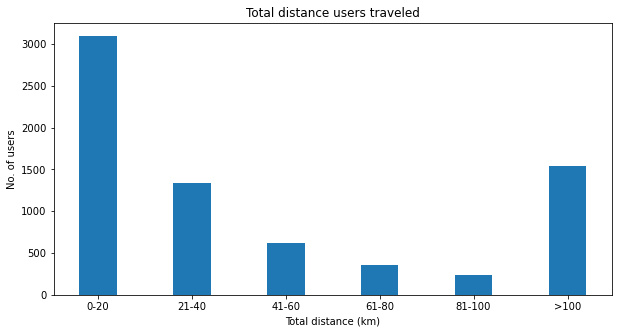

In [ ]:
# plot the barchart of the total distance users traveled
frequency_df = {'0-20': 0, '21-40': 0, '41-60': 0, '61-80': 0, '81-100': 0, '>100': 0}
for idx, row in tqdm.tqdm(users_info.iterrows(), total=users_info.shape[0]):
    data = row['total distance']
    if data <= 20:
        frequency_df['0-20'] += 1
    elif data <= 40:
        frequency_df['21-40'] += 1
    elif data <= 60:
        frequency_df['41-60'] += 1
    elif data <= 80:
        frequency_df['61-80'] += 1
    elif data <= 100:
        frequency_df['81-100'] += 1
    else:
        frequency_df['>100'] += 1

total_distance = list(frequency_df.keys())
values = list(frequency_df.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(total_distance, values, width = 0.4)
 
plt.xlabel("Total distance (km)")
plt.ylabel("No. of users")
plt.title("Total distance users traveled")
plt.show()

100%|██████████| 7183/7183 [00:00<00:00, 25171.54it/s]


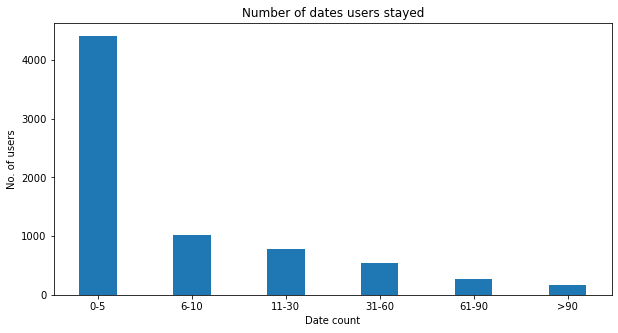

In [ ]:
# plot the barchart of the date count
frequency_df = {'0-5': 0, '6-10': 0, '11-30': 0, '31-60': 0, '61-90': 0, '>90': 0}
for idx, row in tqdm.tqdm(users_info.iterrows(), total=users_info.shape[0]):
    data = row['date count']
    if data <= 5:
        frequency_df['0-5'] += 1
    elif data <= 10:
        frequency_df['6-10'] += 1
    elif data <= 30:
        frequency_df['11-30'] += 1
    elif data <= 60:
        frequency_df['31-60'] += 1
    elif data <= 90:
        frequency_df['61-90'] += 1
    else:
        frequency_df['>90'] += 1

total_distance = list(frequency_df.keys())
values = list(frequency_df.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(total_distance, values, width = 0.4)
 
plt.xlabel("Date count")
plt.ylabel("No. of users")
plt.title("Number of dates users stayed")
plt.show()

In [ ]:
# get locals and tourists candidates and unidentified users
locals_candi = users_info[users_info['tourist']=='n']
tourists_candi = users_info[users_info['tourist']=='y']
unsure_candi = users_info[users_info['tourist']=='unsure']

In [ ]:
locals_candi.describe()

,User ID,interval,total distance,checkins count,date count
count,163.000000,163.000000,163.000000,163.000000,163.000000
mean,119921.411043,136.723926,92.942149,24.141104,14.184049
std,65103.960876,176.493251,170.626246,39.797772,23.890759
min,5163.000000,1.000000,1.144156,2.000000,1.000000
25%,60119.000000,3.000000,6.245730,3.000000,2.000000
50%,107964.000000,19.000000,21.412846,6.000000,4.000000
75%,166855.000000,279.000000,71.882537,22.000000,8.000000
max,256237.000000,531.000000,912.600328,198.000000,94.000000


In [ ]:
# extract possible locals from tourists candidates and unidentified users
tourists_to_locals = tourists_candi[(tourists_candi['date count']>30) & (tourists_candi['total distance']>100)]
unsure_to_locals = unsure_candi[(unsure_candi['date count']>30) & (unsure_candi['total distance']>100)]

# get the user id of final locals
locals_ls = list(locals_candi['User ID']) + list(tourists_to_locals['User ID']) + list(unsure_to_locals['User ID'])

# update the identification of locals and touritst in users_info
for idx, row in tqdm.tqdm(users_info.iterrows(), total=users_info.shape[0]):
    user_id = row['User ID']
    if user_id in locals_ls:
        users_info.loc[idx, 'tourist'] = 'n'
    else:
        users_info.loc[idx, 'tourist'] = 'y'

100%|██████████| 7183/7183 [00:00<00:00, 10257.66it/s]


In [ ]:
# get locals and tourists
locals_info = users_info[users_info['tourist']=='n']
tourists_info = users_info[users_info['tourist']=='y']

In [ ]:
locals_info

,User ID,interval,total distance,checkins count,date count
count,1087.000000,1087.000000,1087.000000,1087.000000,1087.000000
mean,126973.251150,374.789328,406.585131,100.789328,59.807728
std,75565.464371,167.495265,438.642823,116.047479,40.316118
min,144.000000,1.000000,1.144156,2.000000,1.000000
25%,60421.500000,285.500000,197.895497,53.000000,38.000000
50%,121389.000000,453.000000,314.330271,75.000000,53.000000
75%,189111.500000,512.000000,487.429798,114.000000,75.000000
max,266180.000000,532.000000,5469.198768,1573.000000,323.000000


In [ ]:
tourists_info

,User ID,country_code,home_city,interval,total distance,checkins count,date count,tourist
0,9,None,None,2,19.094157,10,2,y
1,55,US,"Jakarta, Jakarta, Indonesia",410,100.384101,44,13,y
2,65,US,"New York, NY",20,9.286309,2,2,y
3,116,None,None,142,70.665094,27,3,y
5,151,None,None,414,714.510235,168,24,y
...,...,...,...,...,...,...,...,...
7178,266445,US,"New York, NY",23,5.141246,8,5,y
7179,266637,DE,"Fürstenwalde/Spree, Brandenburg",16,59.340305,12,8,y
7180,266894,None,None,71,296.883477,64,30,y
7181,266904,JP,"世田谷区, 日本",4,11.112041,8,4,y


In [ ]:
# merge users_info with gdf_london_merged
gdf_london_cleaned = gdf_london_merged.merge(users_info[['User ID', 'tourist']], on='User ID', how='left')

gdf_london_cleaned

,User ID,Venue ID,Venue category name,geometry,time,date,id,sub_id,category,sub_category,new_category,tourist
0,262915,4aec9f4bf964a52091c921e3,Pub,POINT (-0.09055 51.49804),2012-04-03 18:00:39+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar,Entertainment Place,n
1,176394,4ad9f6ddf964a520751c21e3,Pub,POINT (-0.10401 51.52012),2012-04-03 18:15:19+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar,Entertainment Place,y
2,163591,4ae0acf4f964a5208c8121e3,Pub,POINT (-0.02066 51.58778),2012-04-03 18:38:58+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar,Entertainment Place,n
3,206428,4adb1972f964a5205f2421e3,Pub,POINT (-0.14356 51.55852),2012-04-03 18:41:27+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar,Entertainment Place,n
4,18883,4ac518baf964a520dea120e3,Pub,POINT (-0.17742 51.55664),2012-04-03 18:47:29+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar,Entertainment Place,n
...,...,...,...,...,...,...,...,...,...,...,...,...
177202,544,51692f22e4b04a6f7dca039d,Middle School,POINT (-0.24022 51.48726),2013-04-19 06:38:30+00:00,2013-04-19,16000,16036,Professional & Other Places,School,Professional Place,n
177203,544,51692f22e4b04a6f7dca039d,Middle School,POINT (-0.24022 51.48726),2013-04-21 11:18:59+00:00,2013-04-21,16000,16036,Professional & Other Places,School,Professional Place,n
177204,12623,4f73185be4b042cc9614a94f,Mac & Cheese Joint,POINT (-0.14639 51.54118),2013-06-07 12:58:42+00:00,2013-06-07,13000,13060,Food,Mac & Cheese Joint,Restaurant,n
177205,158095,5196543b498ea8ef66acbc69,Research Laboratory,POINT (-0.14847 51.52229),2013-07-04 15:38:07+00:00,2013-07-04,16000,16034,Professional & Other Places,Research Laboratory,Professional Place,n


Save the cleaned data as pickle

In [ ]:
# save the cleaned data as pickle
gdf_london_cleaned.to_pickle(path_foursquare+'london_foursquare_cleaned.pkl')

In [ ]:
gdf_london_cleaned = pd.read_pickle(path_foursquare+'london_foursquare_cleaned.pkl')

In [ ]:
print(gdf_london_cleaned[gdf_london_cleaned['tourist']=='n'].shape[0])
print(gdf_london_cleaned[gdf_london_cleaned['tourist']=='y'].shape[0])

109558
67649


Save the cleaned data as csv

In [ ]:
# convert geodataframe to dataframe
gdf_london_cleaned['lon'] = 0
gdf_london_cleaned['lat'] = 0

gdf_london_cleaned['lon'] = gdf_london_cleaned['geometry'].apply(lambda geo: geo.x)
gdf_london_cleaned['lat'] = gdf_london_cleaned['geometry'].apply(lambda geo: geo.y)

gdf_london_cleaned = gdf_london_cleaned.drop(columns='geometry')

gdf_london_cleaned = pd.DataFrame(gdf_london_cleaned)

gdf_london_cleaned


,User ID,Venue ID,Venue category name,time,date,id,sub_id,category,sub_category,new_category,tourist,lon,lat
0,262915,4aec9f4bf964a52091c921e3,Pub,2012-04-03 18:00:39+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar,Entertainment Place,n,-0.090546,51.498044
1,176394,4ad9f6ddf964a520751c21e3,Pub,2012-04-03 18:15:19+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar,Entertainment Place,y,-0.104010,51.520118
2,163591,4ae0acf4f964a5208c8121e3,Pub,2012-04-03 18:38:58+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar,Entertainment Place,n,-0.020657,51.587781
3,206428,4adb1972f964a5205f2421e3,Pub,2012-04-03 18:41:27+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar,Entertainment Place,n,-0.143561,51.558523
4,18883,4ac518baf964a520dea120e3,Pub,2012-04-03 18:47:29+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar,Entertainment Place,n,-0.177416,51.556636
...,...,...,...,...,...,...,...,...,...,...,...,...,...
177202,544,51692f22e4b04a6f7dca039d,Middle School,2013-04-19 06:38:30+00:00,2013-04-19,16000,16036,Professional & Other Places,School,Professional Place,n,-0.240222,51.487264
177203,544,51692f22e4b04a6f7dca039d,Middle School,2013-04-21 11:18:59+00:00,2013-04-21,16000,16036,Professional & Other Places,School,Professional Place,n,-0.240222,51.487264
177204,12623,4f73185be4b042cc9614a94f,Mac & Cheese Joint,2013-06-07 12:58:42+00:00,2013-06-07,13000,13060,Food,Mac & Cheese Joint,Restaurant,n,-0.146395,51.541176
177205,158095,5196543b498ea8ef66acbc69,Research Laboratory,2013-07-04 15:38:07+00:00,2013-07-04,16000,16034,Professional & Other Places,Research Laboratory,Professional Place,n,-0.148466,51.522290


In [ ]:
gdf_london_cleaned = pd.read_csv(path_foursquare+'london_foursquare_cleaned.csv')

In [ ]:
gdf_london_cleaned

,Unnamed: 0,User ID,Venue ID,Venue category name,time,date,id,sub_id,category,sub_category,new_category,checkins count,tourist,lon,lat
0,0,262915,4aec9f4bf964a52091c921e3,Pub,2012-04-03 18:00:39+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar,Entertainment Place,74,y,-0.090546,51.498044
1,1,176394,4ad9f6ddf964a520751c21e3,Pub,2012-04-03 18:15:19+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar,Entertainment Place,15,y,-0.104010,51.520118
2,2,163591,4ae0acf4f964a5208c8121e3,Pub,2012-04-03 18:38:58+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar,Entertainment Place,95,unsure,-0.020657,51.587781
3,3,206428,4adb1972f964a5205f2421e3,Pub,2012-04-03 18:41:27+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar,Entertainment Place,59,y,-0.143561,51.558523
4,4,18883,4ac518baf964a520dea120e3,Pub,2012-04-03 18:47:29+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar,Entertainment Place,334,y,-0.177416,51.556636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177202,177202,544,51692f22e4b04a6f7dca039d,Middle School,2013-04-19 06:38:30+00:00,2013-04-19,16000,16036,Professional & Other Places,School,Professional Place,634,y,-0.240222,51.487264
177203,177203,544,51692f22e4b04a6f7dca039d,Middle School,2013-04-21 11:18:59+00:00,2013-04-21,16000,16036,Professional & Other Places,School,Professional Place,634,y,-0.240222,51.487264
177204,177204,12623,4f73185be4b042cc9614a94f,Mac & Cheese Joint,2013-06-07 12:58:42+00:00,2013-06-07,13000,13060,Food,Mac & Cheese Joint,Restaurant,166,unsure,-0.146395,51.541176
177205,177205,158095,5196543b498ea8ef66acbc69,Research Laboratory,2013-07-04 15:38:07+00:00,2013-07-04,16000,16034,Professional & Other Places,Research Laboratory,Professional Place,77,y,-0.148466,51.522290


## Exploration & Unadopted Approaches

In [ ]:
# merge users_info with gdf_london_merged
gdf_london_merged = gdf_london_merged.merge(users_info, on='User ID', how='left')

gdf_london_merged

,User ID,Venue ID,Venue category name,geometry,time,date,id,sub_id,category,sub_category,new_category,country_code,home_city,interval,total distance,checkins count,date count,tourist
0,262915,4aec9f4bf964a52091c921e3,Pub,POINT (-0.09055 51.49804),2012-04-03 18:00:39+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar,Entertainment Place,JP,"千代田区, 東京都",511,268.293764,74,56,y
1,176394,4ad9f6ddf964a520751c21e3,Pub,POINT (-0.10401 51.52012),2012-04-03 18:15:19+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar,Entertainment Place,US,"Huntersvile, NC",306,32.458622,15,13,y
2,163591,4ae0acf4f964a5208c8121e3,Pub,POINT (-0.02066 51.58778),2012-04-03 18:38:58+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar,Entertainment Place,None,None,250,279.750342,95,43,unsure
3,206428,4adb1972f964a5205f2421e3,Pub,POINT (-0.14356 51.55852),2012-04-03 18:41:27+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar,Entertainment Place,US,"Birmingham, al",514,378.467169,59,40,y
4,18883,4ac518baf964a520dea120e3,Pub,POINT (-0.17742 51.55664),2012-04-03 18:47:29+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar,Entertainment Place,US,NYC,140,1316.280468,334,75,y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177202,544,51692f22e4b04a6f7dca039d,Middle School,POINT (-0.24022 51.48726),2013-04-19 06:38:30+00:00,2013-04-19,16000,16036,Professional & Other Places,School,Professional Place,US,"Walnut Creek, CA",528,4425.019094,634,225,y
177203,544,51692f22e4b04a6f7dca039d,Middle School,POINT (-0.24022 51.48726),2013-04-21 11:18:59+00:00,2013-04-21,16000,16036,Professional & Other Places,School,Professional Place,US,"Walnut Creek, CA",528,4425.019094,634,225,y
177204,12623,4f73185be4b042cc9614a94f,Mac & Cheese Joint,POINT (-0.14639 51.54118),2013-06-07 12:58:42+00:00,2013-06-07,13000,13060,Food,Mac & Cheese Joint,Restaurant,None,None,475,645.809301,166,102,unsure
177205,158095,5196543b498ea8ef66acbc69,Research Laboratory,POINT (-0.14847 51.52229),2013-07-04 15:38:07+00:00,2013-07-04,16000,16034,Professional & Other Places,Research Laboratory,Professional Place,US,"Grand Forks, ND",530,292.735184,77,63,y


In [ ]:
# get locals
gdf_london_merged_locals = gdf_london_merged[gdf_london_merged['tourist']=='n']

# get tourists
gdf_london_merged_tourists = gdf_london_merged[gdf_london_merged['tourist']=='y']

# get users not identified
gdf_london_merged_unsure = gdf_london_merged[gdf_london_merged['tourist']=='unsure']

In [ ]:
# group the data by user id
gdf_gb_locals = gdf_london_merged_locals.groupby('User ID', as_index=False)

gdf_gb_tourists = gdf_london_merged_tourists.groupby('User ID', as_index=False)

gdf_gb_unsure = gdf_london_merged_unsure.groupby('User ID', as_index=False)

In [ ]:
# get locals
locals_info = users_info[users_info['tourist']=='n']
print(len(locals_info))

# get tourists
tourists_info = users_info[users_info['tourist']=='y']
print(len(tourists_info))

# get users not identified
unsure_info = users_info[users_info['tourist']=='unsure']
print(len(unsure_info))


163
6164
856


In [ ]:
users_info.columns

Index(['User ID', 'country_code', 'home_city', 'interval', 'total distance',
       'checkins count', 'date count', 'tourist'],
      dtype='object')

In [ ]:
users_30 = users_info[users_info['date count']>=30]
users_30.describe()

,User ID,interval,total distance,checkins count,date count
count,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000
mean,128899.512948,413.836653,442.133249,110.877490,66.276892
std,76716.134450,127.504052,438.632566,115.953673,36.482928
min,144.000000,34.000000,9.855263,31.000000,30.000000
25%,61535.750000,337.750000,226.877675,60.000000,42.000000
50%,125329.500000,472.000000,334.350181,79.500000,56.000000
75%,191605.000000,514.000000,511.921257,119.000000,78.000000
max,266894.000000,532.000000,5469.198768,1573.000000,323.000000


In [ ]:
locals_30 = locals_info[locals_info['date count']>=30]
locals_30.describe()

,User ID,interval,total distance,checkins count,date count
count,27.000000,27.000000,27.000000,27.000000,27.000000
mean,110231.000000,407.703704,403.363697,102.666667,63.592593
std,68336.610688,139.094825,219.787532,40.197589,20.494388
min,17220.000000,57.000000,109.445633,38.000000,30.000000
25%,57506.500000,339.500000,228.258109,71.500000,47.000000
50%,98766.000000,482.000000,379.044314,100.000000,62.000000
75%,140052.000000,515.000000,546.156712,125.500000,82.500000
max,256237.000000,531.000000,912.600328,198.000000,94.000000


In [ ]:
tourists_30 = tourists_info[tourists_info['date count']>=30]
tourists_30.describe()

,User ID,interval,total distance,checkins count,date count
count,843.000000,843.000000,843.000000,843.000000,843.000000
mean,128909.218268,417.212337,450.486697,110.483986,66.322657
std,76482.092696,124.564996,451.902133,111.353818,36.257594
min,144.000000,34.000000,9.855263,31.000000,30.000000
25%,62754.500000,344.000000,230.690977,60.000000,42.000000
50%,127918.000000,473.000000,337.143184,79.000000,56.000000
75%,191493.000000,515.000000,521.789414,119.000000,78.000000
max,266180.000000,532.000000,5469.198768,1240.000000,295.000000


In [ ]:
tourists_30[tourists_30['total distance']>500]

,User ID,country_code,home_city,interval,total distance,checkins count,date count,tourist
4,144,US,"New York, NY",349,3567.730959,1240,252,y
26,544,US,"Walnut Creek, CA",528,4425.019094,634,225,y
32,722,US,"Oxnard, California",287,1775.691290,1134,116,y
37,876,US,"Minneapolis, MN",340,3399.931862,908,88,y
39,1022,US,"Chicago, IL",290,2100.088915,934,200,y
...,...,...,...,...,...,...,...,...
6071,218651,CA,"Liverpool, England",519,666.687592,76,68,y
6362,231497,US,"Springfield, IL",500,572.236202,72,56,y
6700,246007,US,"San Francisco, CA",457,515.522758,70,45,y
6795,250380,AU,"Wantirna South, Australia",335,630.215065,77,49,y


[Text(1, 0, 'Locals'), Text(2, 0, 'Tourists')]

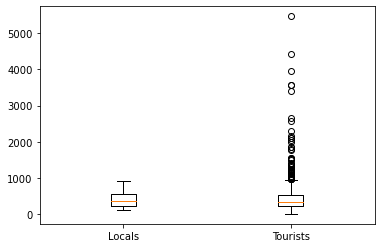

In [ ]:
variable = 'total distance'
my_dict = {'Locals': locals_30[variable], 'Tourists': tourists_30[variable]}

fig, ax = plt.subplots()
ax.boxplot(my_dict.values())
ax.set_xticklabels(my_dict.keys())


In [ ]:
locals_info['distance per day'] = locals_info['total distance']/locals_info['date count']
locals_info['checkins per day'] = locals_info['checkins count']/locals_info['date count']

tourists_info['distance per day'] = tourists_info['total distance']/tourists_info['date count']
tourists_info['checkins per day'] = tourists_info['checkins count']/tourists_info['date count']

In [ ]:
locals_info.describe()

,User ID,interval,total distance,checkins count,date count,distance per day,checkins per day
count,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000
mean,119921.411043,136.723926,92.942149,24.141104,14.184049,6.354469,2.005024
std,65103.960876,176.493251,170.626246,39.797772,23.890759,5.279293,1.306033
min,5163.000000,1.000000,1.144156,2.000000,1.000000,0.422789,1.000000
25%,60119.000000,3.000000,6.245730,3.000000,2.000000,3.051407,1.308497
50%,107964.000000,19.000000,21.412846,6.000000,4.000000,4.640261,1.666667
75%,166855.000000,279.000000,71.882537,22.000000,8.000000,8.023722,2.083916
max,256237.000000,531.000000,912.600328,198.000000,94.000000,31.949431,12.000000


In [ ]:
tourists_info.describe()

,User ID,interval,total distance,checkins count,date count,distance per day,checkins per day
count,6164.000000,6164.000000,6164.000000,6164.000000,6164.000000,6164.000000,6164.000000
mean,124952.424075,148.846528,94.348985,24.294452,13.668235,6.817571,2.077209
std,77651.634770,179.667461,224.668299,54.917312,25.362632,6.243767,1.499609
min,55.000000,1.000000,1.001858,2.000000,1.000000,0.116308,1.000000
25%,55017.250000,3.000000,8.928823,4.000000,2.000000,2.978562,1.250000
50%,121469.500000,36.000000,25.185113,8.000000,4.000000,5.442984,1.625000
75%,191517.500000,295.000000,76.685667,20.000000,10.000000,9.008881,2.333333
max,266908.000000,532.000000,5469.198768,1240.000000,295.000000,166.250832,32.000000


### Explore Features

Explore Time Interval

In [ ]:
locals_info['interval'].describe()

count    163.000000
mean     136.723926
std      176.493251
min        1.000000
25%        3.000000
50%       19.000000
75%      279.000000
max      531.000000
Name: interval, dtype: float64

In [ ]:
tourists_info['interval'].describe()

count    6164.000000
mean      148.846528
std       179.667461
min         1.000000
25%         3.000000
50%        36.000000
75%       295.000000
max       532.000000
Name: interval, dtype: float64

In [ ]:
unsure_info['interval'].describe()

count    856.000000
mean     149.737150
std      182.546323
min        1.000000
25%        4.000000
50%       27.500000
75%      301.250000
max      532.000000
Name: interval, dtype: float64

(array([24., 15.,  7.,  8.,  3.,  8.,  1.,  1.,  1.,  3.,  1.,  2.,  0.,
         2.,  0.,  1.,  1.,  1.,  3.,  2.,  0.,  0.,  1.,  0.,  1.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  2.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

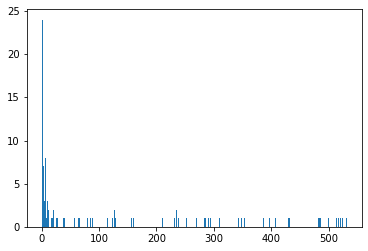

In [ ]:
# plot the frequency
data = locals_info['interval']
plt.hist(data, bins=np.arange(data.min(), data.max()+1))

(array([521., 576., 450., 305., 236., 131., 107.,  78.,  71.,  55.,  43.,
         32.,  47.,  38.,  33.,  30.,  24.,  24.,  24.,  23.,  30.,  23.,
         15.,  20.,  15.,  18.,  15.,  16.,  15.,   6.,  12.,  11.,  14.,
          9.,  14.,   6.,   8.,   8.,   6.,  15.,   5.,   3.,   9.,   3.,
          5.,   9.,   5.,   7.,  12.,  11.,   6.,   8.,   9.,   5.,   6.,
          6.,   8.,   7.,  10.,   7.,   7.,  10.,   9.,   9.,  11.,  11.,
          8.,   7.,   8.,  11.,   9.,   8.,   7.,   9.,   4.,   9.,   5.,
         11.,   8.,   3.,   4.,   5.,   9.,   8.,  11.,   2.,   5.,   4.,
          4.,   2.,  10.,   5.,   3.,   9.,   5.,   5.,   7.,   5.,  10.,
          4.,   3.,   6.,   7.,   7.,  10.,   6.,  11.,   4.,   6.,   5.,
          9.,  10.,   6.,   7.,   9.,   7.,   4.,   6.,   5.,   5.,   6.,
          9.,   6.,   1.,   8.,   2.,   7.,   5.,   4.,   0.,   3.,   1.,
          7.,   8.,   4.,   5.,   3.,   8.,   6.,   5.,   8.,   5.,  14.,
          7.,   5.,   5.,   6.,   5., 

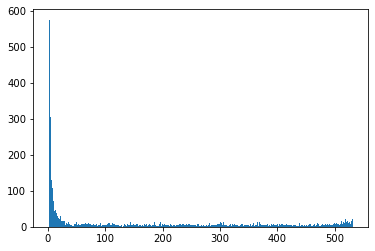

In [ ]:
# plot the frequency
data = tourists_info['interval']
plt.hist(data, bins=np.arange(data.min(), data.max()+1))

(array([78., 67., 64., 50., 36., 16., 25., 18.,  5.,  7.,  2.,  3.,  8.,
         3.,  9.,  5.,  4.,  4.,  4.,  4.,  4.,  2.,  4.,  2.,  0.,  2.,
         2.,  2.,  7.,  2.,  2.,  2.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,
         0.,  2.,  2.,  0.,  0.,  2.,  0.,  0.,  1.,  0.,  0.,  3.,  1.,
         1.,  1.,  2.,  0.,  0.,  1.,  2.,  1.,  1.,  0.,  2.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  4.,  1.,  0.,  0.,  1.,  2.,  1.,  2.,
         1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,
         1.,  2.,  1.,  1.,  0.,  1.,  0.,  2.,  1.,  2.,  1.,  1.,  2.,
         0.,  0.,  1.,  0.,  0.,  2.,  0.,  0.,  2.,  0.,  2.,  0.,  1.,
         1.,  1.,  0.,  1.,  2.,  1.,  0.,  1.,  1.,  0.,  1.,  0.,  2.,
         3.,  1.,  0.,  1.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  2.,  2.,
         0.,  0.,  2.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,
         0.,  3.,  2.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  0.

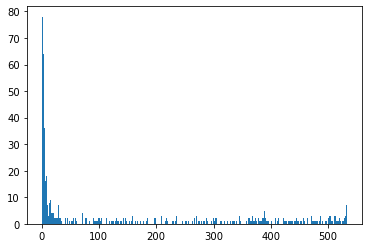

In [ ]:
# plot the frequency
data = unsure_info['interval']
plt.hist(data, bins=np.arange(data.min(), data.max()+1))

Explore Travel Distance

In [ ]:
locals_info['total distance'].describe()

count    163.000000
mean      92.942149
std      170.626246
min        1.144156
25%        6.245730
50%       21.412846
75%       71.882537
max      912.600328
Name: total distance, dtype: float64

In [ ]:
tourists_info['total distance'].describe()

count    6164.000000
mean       94.348985
std       224.668299
min         1.001858
25%         8.928823
50%        25.185113
75%        76.685667
max      5469.198768
Name: total distance, dtype: float64

In [ ]:
unsure_info['total distance'].describe()

count     856.000000
mean       96.532139
std       207.705629
min         1.025840
25%         9.372841
50%        26.055522
75%        89.867957
max      3188.422348
Name: total distance, dtype: float64

(array([8., 9., 6., 8., 9., 4., 4., 3., 3., 2., 2., 5., 2., 1., 3., 2., 1.,
        4., 2., 3., 3., 4., 4., 3., 1., 0., 2., 1., 1., 3., 1., 1., 1., 1.,
        1., 2., 1., 0., 0., 2., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 

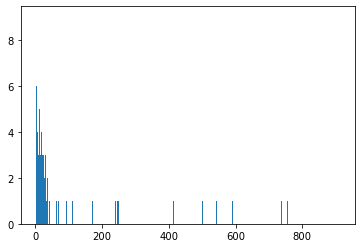

In [ ]:
# plot the frequency
data = locals_info['total distance']
plt.hist(data, bins=np.arange(data.min(), data.max()+1))

(array([227., 263., 240., ...,   0.,   0.,   1.]),
 array([1.00185834e+00, 2.00185834e+00, 3.00185834e+00, ...,
        5.46800186e+03, 5.46900186e+03, 5.47000186e+03]),
 <BarContainer object of 5469 artists>)

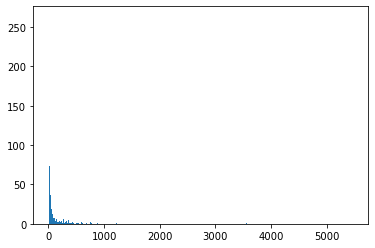

In [ ]:
# plot the frequency
data = tourists_info['total distance']
plt.hist(data, bins=np.arange(data.min(), data.max()+1))

(array([31., 29., 34., ...,  0.,  0.,  1.]),
 array([1.02584006e+00, 2.02584006e+00, 3.02584006e+00, ...,
        3.18702584e+03, 3.18802584e+03, 3.18902584e+03]),
 <BarContainer object of 3188 artists>)

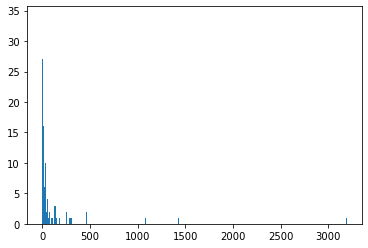

In [ ]:
# plot the frequency
data = unsure_info['total distance']
plt.hist(data, bins=np.arange(data.min(), data.max()+1))


Explore Checkins Numbers

In [ ]:
locals_info['checkins count'].describe()

count    163.000000
mean      24.141104
std       39.797772
min        2.000000
25%        3.000000
50%        6.000000
75%       22.000000
max      198.000000
Name: checkins count, dtype: float64

In [ ]:
tourists_info['checkins count'].describe()

count    6164.000000
mean       24.294452
std        54.917312
min         2.000000
25%         4.000000
50%         8.000000
75%        20.000000
max      1240.000000
Name: checkins count, dtype: float64

In [ ]:
unsure_info['checkins count'].describe()

count     856.000000
mean       27.477804
std        71.541585
min         2.000000
25%         4.000000
50%         8.000000
75%        24.000000
max      1573.000000
Name: checkins count, dtype: float64

(array([25., 19., 15., 12., 11.,  5., 10.,  8.,  6.,  2.,  3.,  1.,  1.,
         1.,  0.,  0.,  1.,  1.,  0.,  0.,  2.,  3.,  1.,  1.,  1.,  2.,
         1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,
         0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,
         1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,
         1.,  0.,  1.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

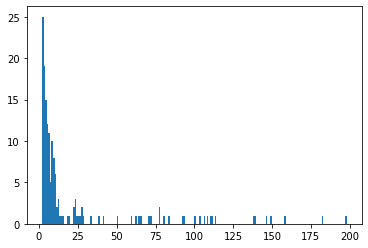

In [ ]:
# plot the frequency
data = locals_info['checkins count']
plt.hist(data, bins=np.arange(data.min(), data.max()+1))

(array([689., 670., 564., ...,   0.,   0.,   1.]),
 array([   2,    3,    4, ..., 1238, 1239, 1240]),
 <BarContainer object of 1238 artists>)

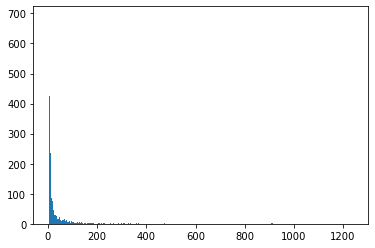

In [ ]:
# plot the frequency
data = tourists_info['checkins count']
plt.hist(data, bins=np.arange(data.min(), data.max()+1))

(array([91., 86., 84., ...,  0.,  0.,  1.]),
 array([   2,    3,    4, ..., 1571, 1572, 1573]),
 <BarContainer object of 1571 artists>)

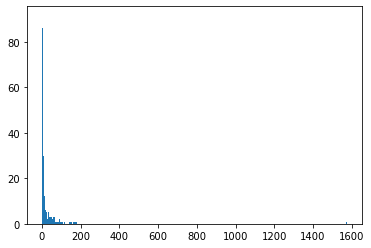

In [ ]:
# plot the frequency
data = unsure_info['checkins count']
plt.hist(data, bins=np.arange(data.min(), data.max()+1))

### Apply Random Forest

https://towardsdatascience.com/a-practical-guide-to-implementing-a-random-forest-classifier-in-python-979988d8a263

Get training and testing sets of locals and tourists seperately and then concat these sets, because the number of tourists is much larger than that of locals.

In [ ]:
from sklearn.model_selection import train_test_split

# get training and testing sets of locals
X_locals = locals_info.drop(['User ID', 'country_code', 'home_city', 'tourist'], axis = 1)
y_locals = locals_info['tourist'].replace('n', 1)
training_locals, testing_locals, training_labels_locals, testing_labels_locals = train_test_split(X_locals, y_locals, test_size = .2, random_state = 21)

# get training and testing sets of tourists
X_tourists = tourists_info.drop(['User ID', 'country_code', 'home_city', 'tourist'], axis = 1)
y_tourists = tourists_info['tourist'].replace('y', 0)
training_tourists, testing_tourists, training_labels_tourists, testing_labels_tourists = train_test_split(X_tourists, y_tourists, test_size = .99, random_state = 42)

# concat training and testing sets
X = pd.concat([X_locals, X_tourists])
y = pd.concat([y_locals, y_tourists])
training = pd.concat([training_locals, training_tourists])
testing = pd.concat([testing_locals, testing_tourists])
training_labels = pd.concat([training_labels_locals, training_labels_tourists])
testing_labels = pd.concat([testing_labels_locals, testing_labels_tourists])

In [ ]:
len(training_labels_tourists)

61

In [ ]:
len(testing_labels_tourists)

6103

In [ ]:
from sklearn.preprocessing import StandardScaler

# normalize the data
sc = StandardScaler()
training_normed = pd.DataFrame(sc.fit_transform(training), columns = X.columns)
testing_normed = pd.DataFrame(sc.fit_transform(testing), columns = X.columns)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# build random forest classifier
clf=RandomForestClassifier()
clf.fit(training_normed, training_labels)

# make prediction
preds = clf.predict(testing_normed)

# metrics are used to find accuracy or error
from sklearn import metrics  
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(testing_labels, preds))

ACCURACY OF THE MODEL:  0.24397001303780966


In [ ]:
len(testing_labels_locals)

33

In [ ]:
len(testing_labels)

3115

In [ ]:
metrics.confusion_matrix(testing_labels, preds,  labels = [0, 1])

array([[3063,   19],
       [  33,    0]], dtype=int64)

In [ ]:
# get the feature importance
pd.DataFrame(clf.feature_importances_, index=training.columns).sort_values(by=0, ascending=False)

,0
total distance,0.599799
interval,0.268230
checkins count,0.131971


In [ ]:
identified = pd.concat([locals_info, tourists_info]).drop(['User ID', 'country_code', 'home_city', 'tourist'], axis = 1)
identified_labels = pd.concat([locals_info, tourists_info])['tourist'].replace({'n': 0, 'y':1})

identified_normed = pd.DataFrame(sc.fit_transform(identified), columns=identified.columns)
unidentified_normed = pd.DataFrame(sc.fit_transform(unsure_info.drop(['User ID', 'country_code', 'home_city', 'tourist'], axis = 1)), columns = X.columns)

# build random forest classifier
clf=RandomForestClassifier()
clf.fit(identified_normed, identified_labels)

# make predictions to unidentified users
unsure_preds = clf.predict(unidentified_normed)

In [ ]:
unsure_preds

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
unsure_info['tourist'] = list(unsure_preds)
unsure_info

C:\Users\leyix\AppData\Local\Temp\ipykernel_20776\2557785121.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unsure_info['tourist'] = list(unsure_preds)


,User ID,country_code,home_city,interval,total distance,checkins count,tourist
0,9,None,None,2,19.094157,10,0
3,116,None,None,142,70.665094,27,0
5,151,None,None,414,714.510235,168,0
6,167,None,None,4,74.068413,34,0
7,172,None,None,1,11.262029,3,0
...,...,...,...,...,...,...,...
7140,264351,JP,None,6,8.197130,2,0
7153,264785,None,None,15,96.052735,18,0
7154,264793,None,None,388,115.744729,61,0
7172,265825,None,None,204,82.181889,27,0


In [ ]:
unsure_info[unsure_info['tourist']==0]

,User ID,country_code,home_city,interval,total distance,checkins count,tourist
0,9,None,None,2,19.094157,10,0
3,116,None,None,142,70.665094,27,0
5,151,None,None,414,714.510235,168,0
6,167,None,None,4,74.068413,34,0
7,172,None,None,1,11.262029,3,0
...,...,...,...,...,...,...,...
7140,264351,JP,None,6,8.197130,2,0
7153,264785,None,None,15,96.052735,18,0
7154,264793,None,None,388,115.744729,61,0
7172,265825,None,None,204,82.181889,27,0


# Explore Data

In [ ]:
# extract hour and day of week
gdf_london_cleaned['hour'] = gdf_london_cleaned['time'].apply(lambda x: x.hour)
gdf_london_cleaned['day_of_week'] = gdf_london_cleaned['time'].apply(lambda x: x.dayofweek)
gdf_london_cleaned['day_name'] = gdf_london_cleaned['time'].apply(lambda x: x.day_name())

# get data of locals and tourists
gdf_london_cleaned_locals = gdf_london_cleaned[gdf_london_cleaned['tourist']=='n']
gdf_london_cleaned_tourists = gdf_london_cleaned[gdf_london_cleaned['tourist']=='y']

## Explore Categories Distribution

In [ ]:
gdf_london_cleaned.value_counts('category')

category
Travel & Transport             43051
Food                           34376
Professional & Other Places    22184
Outdoors & Recreation          20429
Shop & Service                 19772
Nightlife Spot                 18418
Arts & Entertainment           14285
College & University            4692
dtype: int64

In [ ]:
gdf_london_cleaned.value_counts('new_category')

new_category
Transport              36994
Restaurant             34376
Professional Place     29118
Entertainment Place    22274
Shopping Place         18127
Art Place              11132
Green & Blue Space      8336
Accommodation           5902
Sports Place            5896
Others                  3346
Service Place           1706
dtype: int64

In [ ]:
gdf_london_cleaned[gdf_london_cleaned['new_category']=='Restaurant'].value_counts('sub_category')

sub_category
Coffee Shop                        7538
Cafeteria                          3561
Asian Restaurant                   3550
Restaurant                         1806
Italian Restaurant                 1744
Sandwich Place                     1725
Fast Food Restaurant               1169
Burger Joint                        916
French Restaurant                   876
Indian Restaurant                   863
Pizza Place                         821
Gastropub                           721
Mexican Restaurant                  692
Dessert Shop                        689
Portuguese Restaurant               651
Bakery                              594
American Restaurant                 576
Breakfast Spot                      485
Middle Eastern Restaurant           437
Tea Room                            410
Steakhouse                          409
Deli / Bodega                       366
Seafood Restaurant                  321
Diner                               318
Spanish Restaurant         

### Get the number and percent of check-ins in each category

In [ ]:
# get the total number of each category in gdf_london_merged
category_count = gdf_london_cleaned.value_counts('new_category').to_frame(name='total')

# merge with the category count of locals
category_count = category_count.merge(gdf_london_cleaned_locals.value_counts('new_category').to_frame(name='locals'), on='new_category')

# merge with the category count of tourists
category_count = category_count.merge(gdf_london_cleaned_tourists.value_counts('new_category').to_frame(name='tourists'), on='new_category')


In [ ]:
# calculate the percent of each category
category_count['locals_percent'] = category_count['locals']/category_count['total'] * 100
category_count['tourists_percent'] = category_count['tourists']/category_count['total'] * 100
category_count

,total,locals,tourists,locals_percent,tourists_percent
new_category,,,,,
Transport,36994,22585,14409,61.050441,38.949559
Restaurant,34376,21965,12411,63.896323,36.103677
Professional Place,29118,18801,10317,64.568308,35.431692
Entertainment Place,22274,14395,7879,64.626919,35.373081
Shopping Place,18127,10987,7140,60.611243,39.388757
Art Place,11132,6089,5043,54.698167,45.301833
Green & Blue Space,8336,4545,3791,54.522553,45.477447
Accommodation,5902,1752,4150,29.684853,70.315147
Sports Place,5896,5137,759,87.126866,12.873134


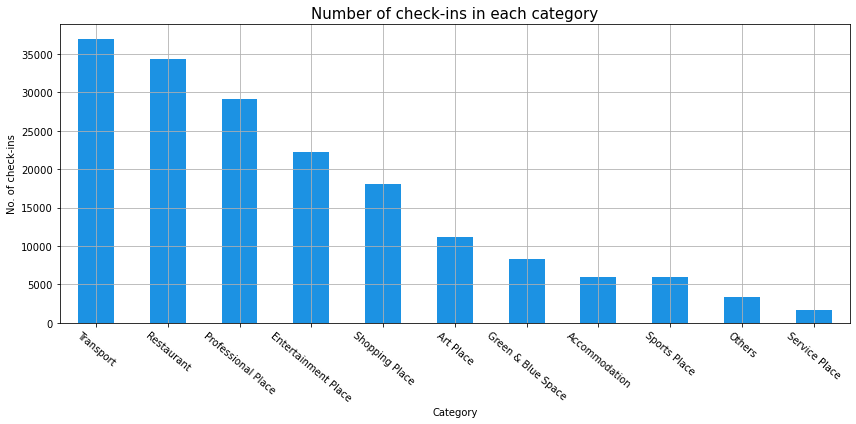

In [ ]:
# plot histogram of venue categories visited by locals
plt.rcParams["figure.figsize"] = [12, 6]
plt.rcParams["figure.autolayout"] = True

ax = category_count['total'].plot.bar(color='#1C92E3')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("Category", fontsize=10)
plt.ylabel("No. of check-ins", fontsize=10)
plt.xticks(rotation = -40)
plt.title('Number of check-ins in each category', fontsize=15)
plt.grid()


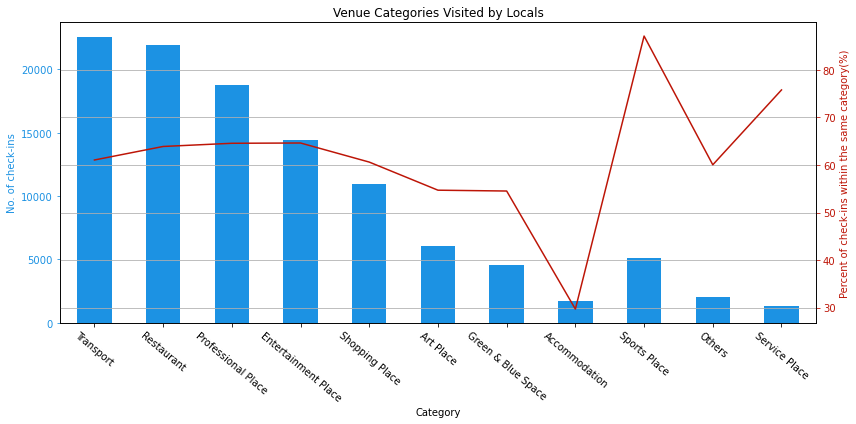

In [ ]:
# plot histogram of venue categories visited by locals
plt.rcParams["figure.figsize"] = [12, 6]
plt.rcParams["figure.autolayout"] = True

y1_color = '#1C92E3'
ax = category_count['locals'].plot.bar(color=y1_color)
ax.set_ylabel("No. of check-ins", color=y1_color)
plt.xlabel("Category")
plt.xticks(rotation = -40)
plt.tick_params(axis='y', colors=y1_color)

y2_color = '#BD1507'
ax2=ax.twinx()
ax2 = category_count['locals_percent'].plot(color=y2_color)
ax2.set_ylabel("Percent of check-ins within the same category(%)",color=y2_color)
ax2.tick_params(axis='y', colors=y2_color)

plt.title('Venue Categories Visited by Locals')
plt.grid()

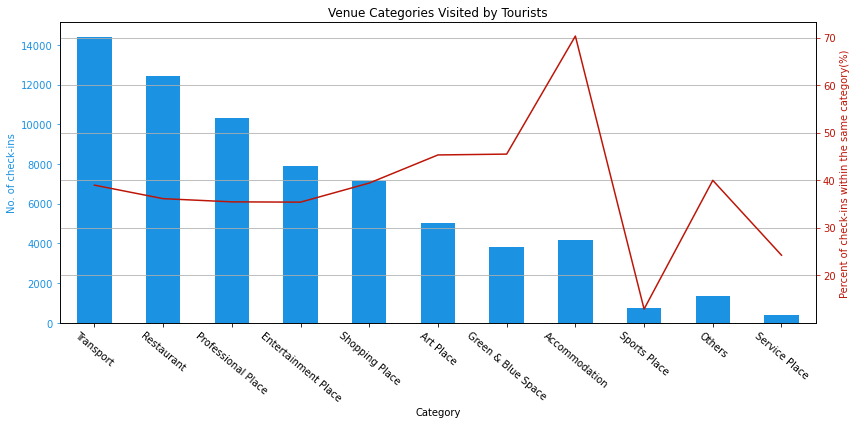

In [ ]:
# plot histogram of venue categories visited by tourists
plt.rcParams["figure.figsize"] = [12, 6]
plt.rcParams["figure.autolayout"] = True

y1_color = '#1C92E3'
ax = category_count['tourists'].plot.bar(color=y1_color)
ax.set_ylabel("No. of check-ins", color=y1_color)
plt.xlabel("Category")
plt.xticks(rotation = -40)
plt.tick_params(axis='y', colors=y1_color)

y2_color = '#BD1507'
ax2=ax.twinx()
ax2 = category_count['tourists_percent'].plot(color=y2_color)
ax2.set_ylabel("Percent of check-ins within the same category(%)",color=y2_color)
ax2.tick_params(axis='y', colors=y2_color)

plt.title('Venue Categories Visited by Tourists')
plt.grid()

### Get the visiting percent of each category check-ins among the total check-ins each user visited

In [ ]:
# count the visiting frequency of each category for every local
foursquare_locals_category = pd.Series(gdf_london_cleaned['new_category'].unique()).to_frame(name='new_category')
foursquare_locals_category

foursquare_locals_gb = gdf_london_cleaned_locals.groupby('User ID')
for i in tqdm.tqdm(foursquare_locals_gb.groups.keys()):
    local_df = foursquare_locals_gb.get_group(i)
    local_category = local_df.value_counts('new_category').to_frame(name=str(i)).reset_index()
    local_category[str(i)] = local_category[str(i)].apply(lambda x: x/sum(local_category[str(i)]))
    foursquare_locals_category = foursquare_locals_category.merge(local_category, on='new_category', how='left')

# replace nan with 0
foursquare_locals_category = foursquare_locals_category.replace(np.NaN, 0)
foursquare_locals_category = foursquare_locals_category.set_index('new_category')

100%|██████████| 1087/1087 [00:03<00:00, 315.73it/s]


In [ ]:
# transpose the dataframe
foursquare_locals_category = foursquare_locals_category.T
foursquare_locals_category

new_category,Entertainment Place,Restaurant,Professional Place,Art Place,Shopping Place,Transport,Accommodation,Green & Blue Space,Sports Place,Others,Service Place
144,0.015323,0.029839,0.205645,0.004839,0.150000,0.448387,0.001613,0.102419,0.000806,0.026613,0.014516
307,0.016636,0.035120,0.214418,0.014787,0.236599,0.201479,0.000000,0.227357,0.009242,0.020333,0.024030
321,0.033058,0.112524,0.086459,0.003814,0.134139,0.535919,0.000636,0.045137,0.009536,0.002543,0.036236
544,0.064669,0.056782,0.129338,0.022082,0.179811,0.162461,0.003155,0.061514,0.063091,0.116719,0.140379
722,0.041446,0.107584,0.142857,0.001764,0.186067,0.373016,0.000882,0.082011,0.004409,0.018519,0.041446
...,...,...,...,...,...,...,...,...,...,...,...
264315,0.166667,0.333333,0.037037,0.074074,0.074074,0.222222,0.000000,0.055556,0.037037,0.000000,0.000000
264793,0.032787,0.295082,0.573770,0.000000,0.065574,0.016393,0.000000,0.016393,0.000000,0.000000,0.000000
264975,0.222222,0.111111,0.365079,0.047619,0.015873,0.015873,0.000000,0.031746,0.190476,0.000000,0.000000
265795,0.021739,0.195652,0.195652,0.239130,0.000000,0.239130,0.021739,0.086957,0.000000,0.000000,0.000000


In [ ]:
foursquare_locals_category.describe()

new_category,Entertainment Place,Restaurant,Professional Place,Art Place,Shopping Place,Transport,Accommodation,Green & Blue Space,Sports Place,Others,Service Place
count,1087.000000,1087.000000,1087.000000,1087.000000,1087.000000,1087.000000,1087.000000,1087.000000,1087.000000,1087.000000,1087.000000
mean,0.152638,0.214754,0.172934,0.069614,0.093324,0.167299,0.022043,0.039739,0.041541,0.017572,0.008542
std,0.149797,0.151765,0.160934,0.096199,0.105315,0.183176,0.061729,0.057716,0.088321,0.052565,0.027435
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.041667,0.103913,0.046934,0.012012,0.025752,0.035714,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.111111,0.195122,0.130000,0.041667,0.065217,0.103448,0.000000,0.020460,0.000000,0.000000,0.000000
75%,0.220339,0.299254,0.255814,0.087434,0.121786,0.239130,0.017468,0.050740,0.034191,0.015524,0.008548
max,1.000000,0.961538,0.868687,0.882353,0.827586,1.000000,0.505639,0.500000,0.695238,0.666667,0.362319


<AxesSubplot:>

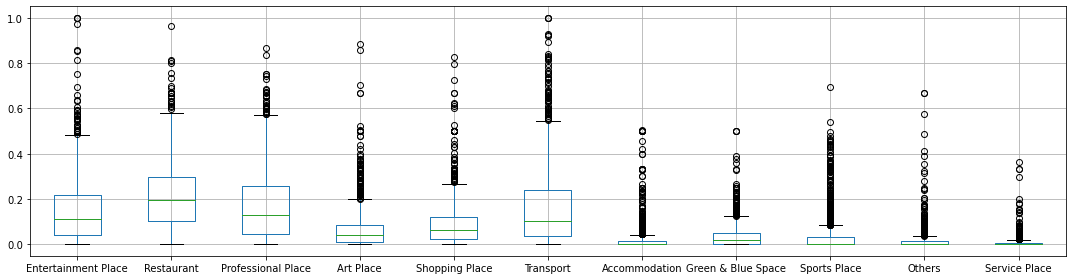

In [ ]:
# plot the boxplot of visiting percent of each user for each category
plt.rcParams["figure.figsize"] = [15, 4]
plt.rcParams["figure.autolayout"] = True

foursquare_locals_category.boxplot() 

In [ ]:
# count the visiting frequency of each category for every tourist
foursquare_tourists_category = pd.Series(gdf_london_cleaned['new_category'].unique()).to_frame(name='new_category')
foursquare_tourists_category

foursquare_tourists_gb = gdf_london_cleaned_tourists.groupby('User ID')
for i in tqdm.tqdm(foursquare_tourists_gb.groups.keys()):
    tourist_df = foursquare_tourists_gb.get_group(i)
    tourist_category = tourist_df.value_counts('new_category').to_frame(name=str(i)).reset_index()
    tourist_category[str(i)] = tourist_category[str(i)].apply(lambda x: x/sum(tourist_category[str(i)]))
    foursquare_tourists_category = foursquare_tourists_category.merge(tourist_category, on='new_category', how='left')

# replace nan with 0
foursquare_tourists_category = foursquare_tourists_category.replace(np.NaN, 0)
foursquare_tourists_category = foursquare_tourists_category.set_index('new_category')

100%|██████████| 6096/6096 [00:20<00:00, 294.58it/s]


In [ ]:
# transpose the dataframe
foursquare_tourists_category = foursquare_tourists_category.T
foursquare_tourists_category

new_category,Entertainment Place,Restaurant,Professional Place,Art Place,Shopping Place,Transport,Accommodation,Green & Blue Space,Sports Place,Others,Service Place
9,0.500000,0.200000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000
55,0.113636,0.250000,0.045455,0.045455,0.136364,0.113636,0.227273,0.000000,0.045455,0.000000,0.022727
65,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
116,0.185185,0.074074,0.148148,0.111111,0.148148,0.222222,0.000000,0.074074,0.037037,0.000000,0.000000
151,0.315476,0.208333,0.184524,0.065476,0.077381,0.047619,0.000000,0.047619,0.005952,0.017857,0.029762
...,...,...,...,...,...,...,...,...,...,...,...
266445,0.000000,0.125000,0.000000,0.000000,0.125000,0.250000,0.500000,0.000000,0.000000,0.000000,0.000000
266637,0.000000,0.083333,0.166667,0.000000,0.166667,0.333333,0.000000,0.250000,0.000000,0.000000,0.000000
266894,0.125000,0.015625,0.203125,0.015625,0.203125,0.296875,0.031250,0.078125,0.000000,0.015625,0.015625
266904,0.000000,0.125000,0.375000,0.125000,0.125000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000


In [ ]:
foursquare_tourists_category.describe()

new_category,Entertainment Place,Restaurant,Professional Place,Art Place,Shopping Place,Transport,Accommodation,Green & Blue Space,Sports Place,Others,Service Place
count,6096.000000,6096.000000,6096.000000,6096.000000,6096.000000,6096.000000,6096.000000,6096.000000,6096.000000,6096.000000,6096.000000
mean,0.129407,0.187548,0.138199,0.086066,0.101588,0.191648,0.075504,0.058304,0.009192,0.018792,0.003752
std,0.196916,0.199778,0.175805,0.144721,0.152750,0.223282,0.141409,0.115936,0.051071,0.065615,0.029008
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.147059,0.071429,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.200000,0.300000,0.235294,0.125000,0.166667,0.333333,0.100000,0.076923,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.833333,0.897436


<AxesSubplot:>

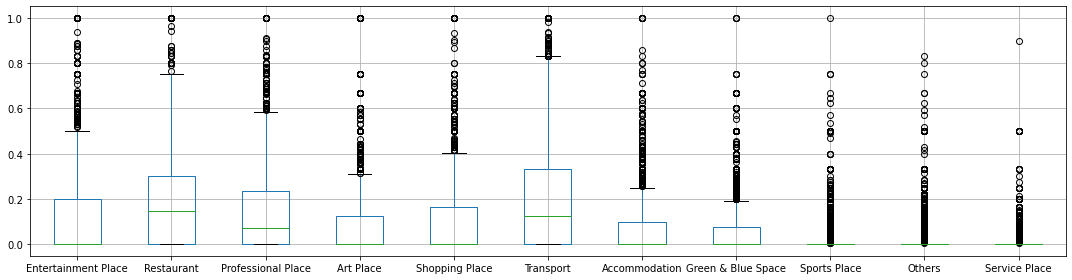

In [ ]:
# plot the boxplot of visiting percent of each user for each category
plt.rcParams["figure.figsize"] = [15, 4]
plt.rcParams["figure.autolayout"] = True

foursquare_tourists_category.boxplot() 

## Explore Popular Venues

### Locals

In [ ]:
# get the locals
df_locals = gdf_london_cleaned[gdf_london_cleaned['tourist']=='n']
df_locals

,User ID,Venue ID,Venue category name,geometry,time,date,id,sub_id,category,sub_category,new_category,tourist
0,262915,4aec9f4bf964a52091c921e3,Pub,POINT (-0.09055 51.49804),2012-04-03 18:00:39+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar,Entertainment Place,n
2,163591,4ae0acf4f964a5208c8121e3,Pub,POINT (-0.02066 51.58778),2012-04-03 18:38:58+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar,Entertainment Place,n
3,206428,4adb1972f964a5205f2421e3,Pub,POINT (-0.14356 51.55852),2012-04-03 18:41:27+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar,Entertainment Place,n
4,18883,4ac518baf964a520dea120e3,Pub,POINT (-0.17742 51.55664),2012-04-03 18:47:29+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar,Entertainment Place,n
5,70148,4ac53702f964a52007b120e3,Pub,POINT (-0.30571 51.50505),2012-04-03 19:02:34+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar,Entertainment Place,n
...,...,...,...,...,...,...,...,...,...,...,...,...
177202,544,51692f22e4b04a6f7dca039d,Middle School,POINT (-0.24022 51.48726),2013-04-19 06:38:30+00:00,2013-04-19,16000,16036,Professional & Other Places,School,Professional Place,n
177203,544,51692f22e4b04a6f7dca039d,Middle School,POINT (-0.24022 51.48726),2013-04-21 11:18:59+00:00,2013-04-21,16000,16036,Professional & Other Places,School,Professional Place,n
177204,12623,4f73185be4b042cc9614a94f,Mac & Cheese Joint,POINT (-0.14639 51.54118),2013-06-07 12:58:42+00:00,2013-06-07,13000,13060,Food,Mac & Cheese Joint,Restaurant,n
177205,158095,5196543b498ea8ef66acbc69,Research Laboratory,POINT (-0.14847 51.52229),2013-07-04 15:38:07+00:00,2013-07-04,16000,16034,Professional & Other Places,Research Laboratory,Professional Place,n


In [ ]:
len(list(df_locals['User ID'].unique()))

1087

In [ ]:
# get the top 20 popular venues
top_venues_locals = df_locals['Venue ID'].value_counts()[0:20]


Foursquare API 1: fsq3SA2r/INEiszcpAcb94IvEE0c2czJftnxoYPSkHBx+x8=   
Foursquare API 2: fsq3C2PSDwUlQNwuiOq0z5ZMci/cq004Vvv9uOVvs77cvQ4=

In [ ]:
# collect venue names via Foursquare API
# https://location.foursquare.com/developer/reference/place-details
headers = {
    "accept": "application/json",
    "Authorization": "fsq3SA2r/INEiszcpAcb94IvEE0c2czJftnxoYPSkHBx+x8="
}

count = 0
for venue_id in top_venues_locals.keys():
  venue_count = top_venues_locals[venue_id]
  venue_category = df_locals[df_locals['Venue ID']==venue_id]['category'].values[0]
  url = "https://api.foursquare.com/v3/places/{}".format(venue_id)
  response = requests.get(url, headers=headers)
  if 'invalid venue specified' not in response.text:
    # print(venue_id)
    # print(response.text)
    response_json = json.loads(response.text)
    venueName = response_json['name']
    print(str(count)+':'+venue_id)
    print(venueName+' & '+str(venue_count)+' & '+venue_category)
    count += 1


0:4acd8e7df964a52044cc20e3
London Waterloo Railway Station (WAT) & 158 & Travel & Transport
1:4acbc300f964a52058c520e3
London Euston Railway Station & 149 & Travel & Transport
2:4af33684f964a520c7eb21e3
London King's Cross Railway Station (KGX) & 111 & Travel & Transport
3:4ae83e74f964a5204bae21e3
London Paddington Railway Station (PAD) & 111 & Travel & Transport
4:4af47862f964a520d6f221e3
London Liverpool Street Railway Station (LST) & 108 & Travel & Transport
5:4d48ffc34509721eeb9b1fb0
Grove Park Traincrew Depot & 98 & Professional & Other Places
6:4c1f76d6e923ef3bbfbe4e54
West Ham DLR Station & 92 & Travel & Transport
7:4c4d624bdb2c20a12730b972
Westfield Stratford City & 92 & Shop & Service
8:4b76d450f964a5205e622ee3
Virgin Active & 92 & Outdoors & Recreation
9:4ac518f7f964a520c6af20e3
London St Pancras International Railway Station (STP) & 89 & Travel & Transport
10:5045b9b7e4b000beffba95f9
Valideus & 89 & Professional & Other Places
11:4aef4cd0f964a52060d721e3
Twickenham Green & 8

### Tourists

In [ ]:
# get the tourists
df_tourists = gdf_london_cleaned[gdf_london_cleaned['tourist']=='y']
df_tourists

,Unnamed: 0,User ID,Venue ID,Venue category name,time,date,id,sub_id,category,sub_category,tourist,lon,lat
0,0,262915,4aec9f4bf964a52091c921e3,Pub,2012-04-03 18:00:39+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar,y,-0.090546,51.498044
1,1,176394,4ad9f6ddf964a520751c21e3,Pub,2012-04-03 18:15:19+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar,y,-0.104010,51.520118
3,3,206428,4adb1972f964a5205f2421e3,Pub,2012-04-03 18:41:27+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar,y,-0.143561,51.558523
4,4,18883,4ac518baf964a520dea120e3,Pub,2012-04-03 18:47:29+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar,y,-0.177416,51.556636
5,5,70148,4ac53702f964a52007b120e3,Pub,2012-04-03 19:02:34+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar,y,-0.305714,51.505048
...,...,...,...,...,...,...,...,...,...,...,...,...,...
182122,182122,218592,51633602e4b02cfd1f77c01e,Well,2013-04-11 08:16:21+00:00,2013-04-11,15000,15065,Outdoors & Recreation,Well,y,-0.191445,51.536016
182123,182123,544,51692f22e4b04a6f7dca039d,Middle School,2013-04-19 06:38:30+00:00,2013-04-19,16000,16036,Professional & Other Places,School,y,-0.240222,51.487264
182124,182124,544,51692f22e4b04a6f7dca039d,Middle School,2013-04-21 11:18:59+00:00,2013-04-21,16000,16036,Professional & Other Places,School,y,-0.240222,51.487264
182126,182126,158095,5196543b498ea8ef66acbc69,Research Laboratory,2013-07-04 15:38:07+00:00,2013-07-04,16000,16034,Professional & Other Places,Research Laboratory,y,-0.148466,51.522290


In [ ]:
len(list(df_tourists['User ID'].unique()))

9097

In [ ]:
# get the top 20 popular venues
top_venues_tourists = df_tourists['Venue ID'].value_counts()[0:20]


Foursquare API 1: fsq3SA2r/INEiszcpAcb94IvEE0c2czJftnxoYPSkHBx+x8=   
Foursquare API 2: fsq3C2PSDwUlQNwuiOq0z5ZMci/cq004Vvv9uOVvs77cvQ4=

In [ ]:
# collect venue names via Foursquare API
# https://location.foursquare.com/developer/reference/place-details
headers = {
    "accept": "application/json",
    "Authorization": "fsq3SA2r/INEiszcpAcb94IvEE0c2czJftnxoYPSkHBx+x8="
}

count = 0
for venue_id in top_venues_tourists.keys():
  venue_count = top_venues_tourists[venue_id]
  venue_category = df_tourists[df_tourists['Venue ID']==venue_id]['category'].values[0]
  url = "https://api.foursquare.com/v3/places/{}".format(venue_id)
  response = requests.get(url, headers=headers)
  if 'invalid venue specified' not in response.text:
    # print(venue_id)
    # print(response.text)
    response_json = json.loads(response.text)
    venueName = response_json['name']
    print(str(count)+':'+venue_id)
    print(venueName+' & '+str(venue_count)+' & '+venue_category)
    count += 1


0:4acd8e7df964a52044cc20e3
London Waterloo Railway Station (WAT) & 1311 & Travel & Transport
1:4acbc300f964a52058c520e3
London Euston Railway Station & 1288 & Travel & Transport
2:4af33684f964a520c7eb21e3
London King's Cross Railway Station (KGX) & 1115 & Travel & Transport
3:4ae83e74f964a5204bae21e3
London Paddington Railway Station (PAD) & 1043 & Travel & Transport
4:4ac518f6f964a52052af20e3
London Victoria Railway Station (VIC) & 905 & Travel & Transport
5:4ac518f7f964a520c6af20e3
London St Pancras International Railway Station (STP) & 728 & Travel & Transport
6:4abf8c03f964a520079120e3
Harrods & 717 & Shop & Service
7:4af47862f964a520d6f221e3
London Liverpool Street Railway Station (LST) & 687 & Travel & Transport
8:4ad08b28f964a52064d820e3
Westfield London & 622 & Shop & Service
9:4c9c6a059c48236a1cb14dee
Piccadilly Circus & 605 & Outdoors & Recreation
10:4c4d624bdb2c20a12730b972
Westfield Stratford City & 555 & Shop & Service
11:4bcc08273740b7139c756365
London St Pancras Internat

## Explore Temporal Check-ins Patterns

Daytime/Nighttime

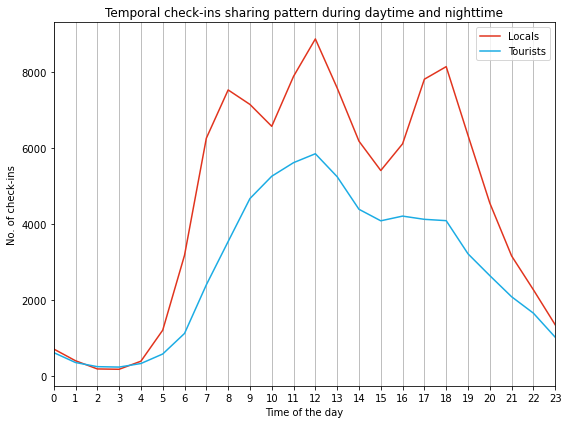

In [ ]:
# count the number of check-ins in each hour
gdf_london_cleaned_locals_gb = gdf_london_cleaned_locals.groupby('hour').count()
data_locals = gdf_london_cleaned_locals_gb['User ID'].reset_index()

gdf_london_cleaned_tourists_gb = gdf_london_cleaned_tourists.groupby('hour').count()
data_tourists = gdf_london_cleaned_tourists_gb['User ID'].reset_index()

plt.rcParams["figure.figsize"] = [8, 6]
plt.rcParams["figure.autolayout"] = True

# define X and Y variable data
x_locals = data_locals['hour']
y_locals = data_locals['User ID']
  
x_tourists = data_tourists['hour']
y_tourists = data_tourists['User ID']

plt.plot(x_locals, y_locals, color='#E1341E', label='Locals')
plt.plot(x_tourists, y_tourists, color='#1bace4', label='Tourists')
plt.legend()

plt.xlabel("Time of the day")  # add X-axis label
plt.ylabel("No. of check-ins")  # add Y-axis label
plt.xticks(range(0, 24))
plt.xlim(0,23)
plt.grid(axis="x")
plt.title("Temporal check-ins sharing pattern during daytime and nighttime")  # add title
plt.show()


In [ ]:
# get data during daytime and nighttime of locals and toursts
daytime_locals = gdf_london_cleaned_locals[(gdf_london_cleaned_locals['hour']>=6) & (gdf_london_cleaned_locals['hour']<=18)]
nighttime_locals = gdf_london_cleaned_locals[(gdf_london_cleaned_locals['hour']<6) | (gdf_london_cleaned_locals['hour']>18)]

daytime_tourists = gdf_london_cleaned_tourists[(gdf_london_cleaned_tourists['hour']>=6) & (gdf_london_cleaned_tourists['hour']<=18)]
nighttime_tourists = gdf_london_cleaned_tourists[(gdf_london_cleaned_tourists['hour']<6) | (gdf_london_cleaned_tourists['hour']>18)]

Weekday/Weekend

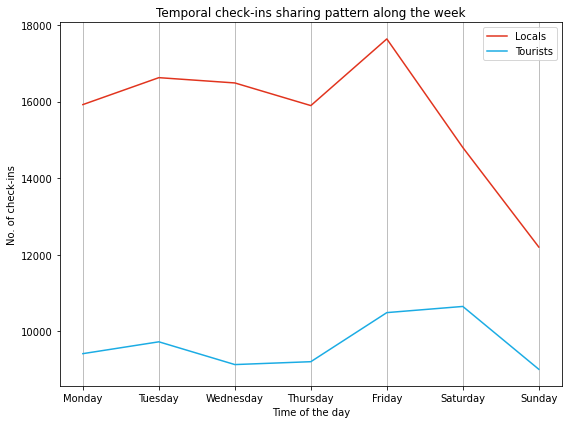

In [ ]:
# count the number of check-ins in each hour
gdf_london_cleaned_locals_gb = gdf_london_cleaned_locals.groupby('day_name').count().reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
data_locals = gdf_london_cleaned_locals_gb['User ID'].reset_index()

gdf_london_cleaned_tourists_gb = gdf_london_cleaned_tourists.groupby('day_name').count().reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
data_tourists = gdf_london_cleaned_tourists_gb['User ID'].reset_index()

plt.rcParams["figure.figsize"] = [8, 6]
plt.rcParams["figure.autolayout"] = True

# define X and Y variable data
x_locals = data_locals['day_name']
y_locals = data_locals['User ID']
  
x_tourists = data_tourists['day_name']
y_tourists = data_tourists['User ID']

plt.plot(x_locals, y_locals, color='#E1341E', label='Locals')
plt.plot(x_tourists, y_tourists, color='#1bace4', label='Tourists')
plt.legend()

plt.xlabel("Time of the day")  # add X-axis label
plt.ylabel("No. of check-ins")  # add Y-axis label
# plt.xticks(range(0, 24))
# plt.xlim(0,23)
plt.grid(axis="x")
plt.title("Temporal check-ins sharing pattern along the week")  # add title
plt.show()

In [ ]:
# get data during weekday and weekend of locals and toursts
weekday_locals = gdf_london_cleaned_locals[gdf_london_cleaned_locals['day_of_week']<=4]
weekend_locals = gdf_london_cleaned_locals[gdf_london_cleaned_locals['day_of_week']>4]

weekday_tourists = gdf_london_cleaned_tourists[gdf_london_cleaned_tourists['day_of_week']<=4]
weekend_tourists = gdf_london_cleaned_tourists[gdf_london_cleaned_tourists['day_of_week']>4]